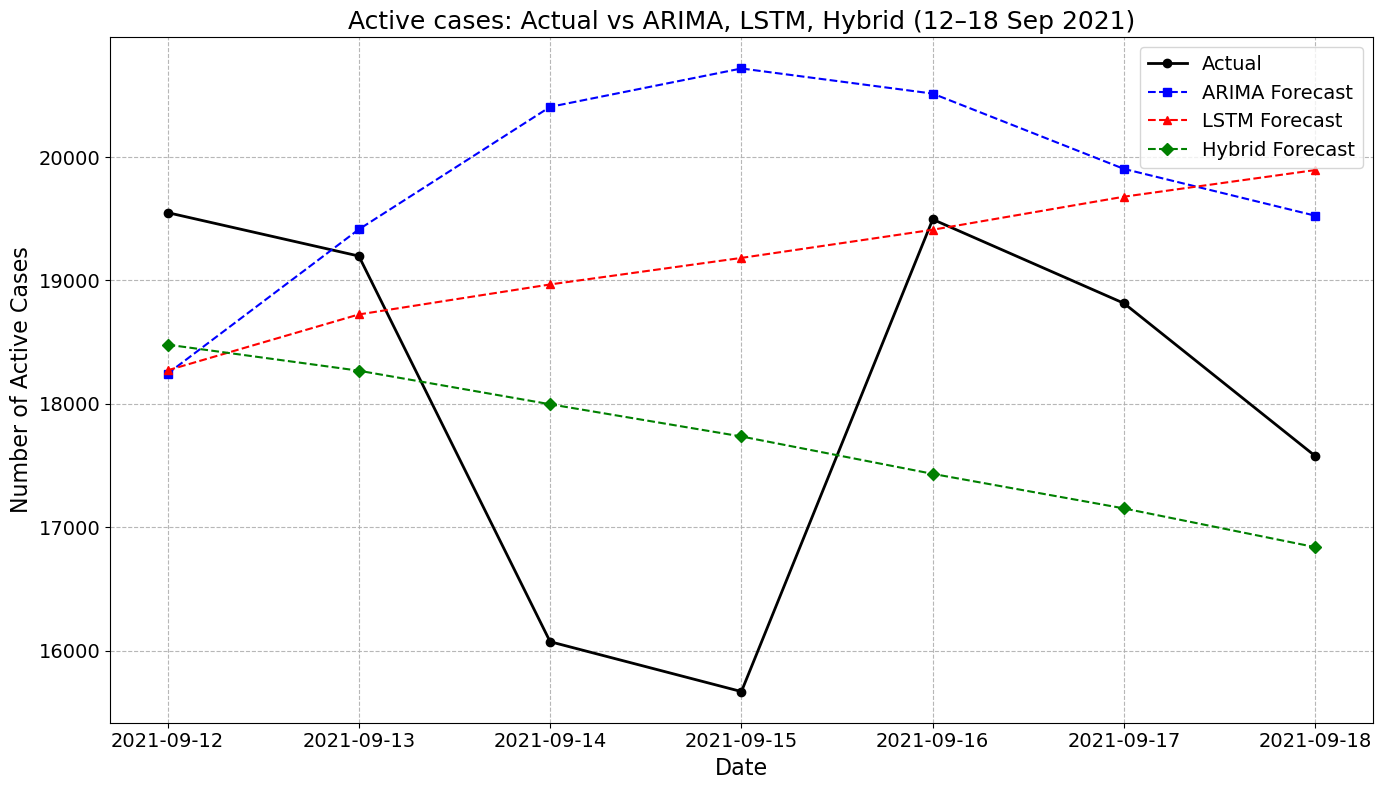

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Dates
dates = pd.date_range(start='2021-09-12', end='2021-09-18')

# Actual values
actual = [19550, 19198, 16073, 15669, 19495, 18815, 17577]

# Forecast values
hybrid = [18480, 18269, 17997, 17736, 17433, 17153, 16839]
lstm = [18271.99, 18724.78, 18967.94, 19182.98, 19411.13, 19678.95, 19894.71]
arima = [18244.78, 19414.10, 20406.76, 20717.74, 20514.25, 19903.91, 19524.77]

# Create DataFrame
df = pd.DataFrame({
    'Actual': actual,
    'ARIMA': arima,
    'LSTM': lstm,
    'Hybrid': hybrid
}, index=dates)

 #Plotting
plt.figure(figsize=(14, 8))  # Bigger figure size

plt.plot(dates, actual, marker='o', label='Actual', color='black', linewidth=2)
plt.plot(dates, arima, marker='s', label='ARIMA Forecast', color='blue', linestyle='--')
plt.plot(dates, lstm, marker='^', label='LSTM Forecast', color='red', linestyle='--')
plt.plot(dates, hybrid, marker='D', label='Hybrid Forecast', color='green', linestyle='--')

# Labels and title with larger fonts
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of Active Cases', fontsize=16)
plt.title('Active cases: Actual vs ARIMA, LSTM, Hybrid (12–18 Sep 2021)', fontsize=18)

# Ticks font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Legend with larger font
plt.legend(fontsize=14)

# Grid and layout
plt.grid(True, linestyle='--', alpha=0.9)
plt.tight_layout()

# Show the plot
plt.show()

17:45:54 - cmdstanpy - INFO - Chain [1] start processing
17:45:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error (MSE): 26142991.04
Mean Absolute Error (MAE): 3925.92
Mean Absolute Percentage Error (MAPE): 20.85%
Root Mean Squared Error (RMSE): 5113.02
Relative RMSE (RRMSE): 0.5726
Normalized RMSE (NRMSE): 0.2532
R-squared (R²): -6.2250


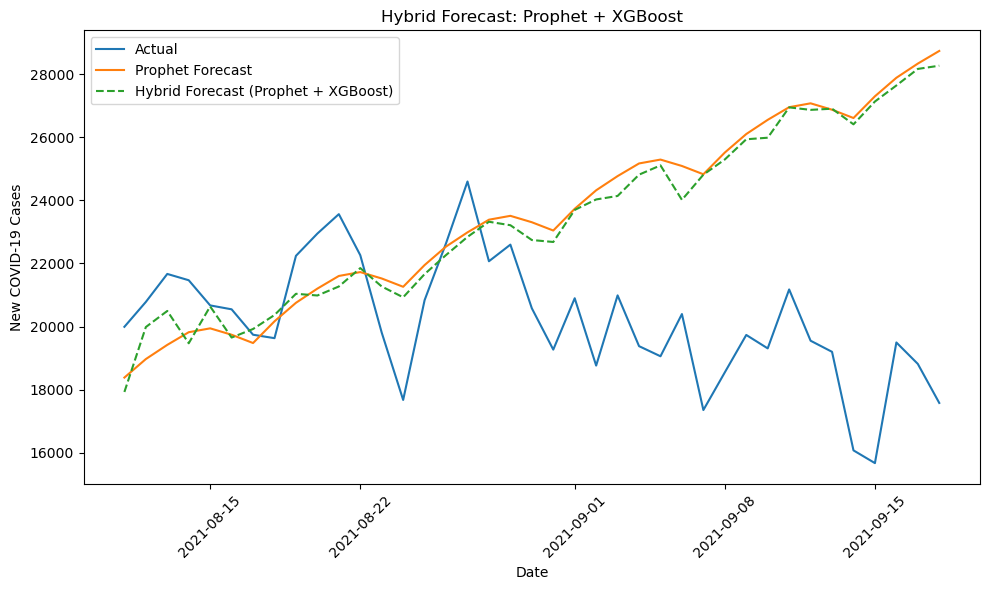


📈 Hybrid Prophet + XGBoost Forecast (12–18 Sept 2021):
         Date  Actual       Prophet  Hybrid_Forecast
32 2021-09-12   19550  27078.068939     26870.635146
33 2021-09-13   19198  26875.193374     26907.275203
34 2021-09-14   16073  26612.167423     26412.364582
35 2021-09-15   15669  27301.058562     27135.298217
36 2021-09-16   19495  27887.911634     27643.897871
37 2021-09-17   18815  28337.987946     28169.212570
38 2021-09-18   17577  28739.128020     28270.900755


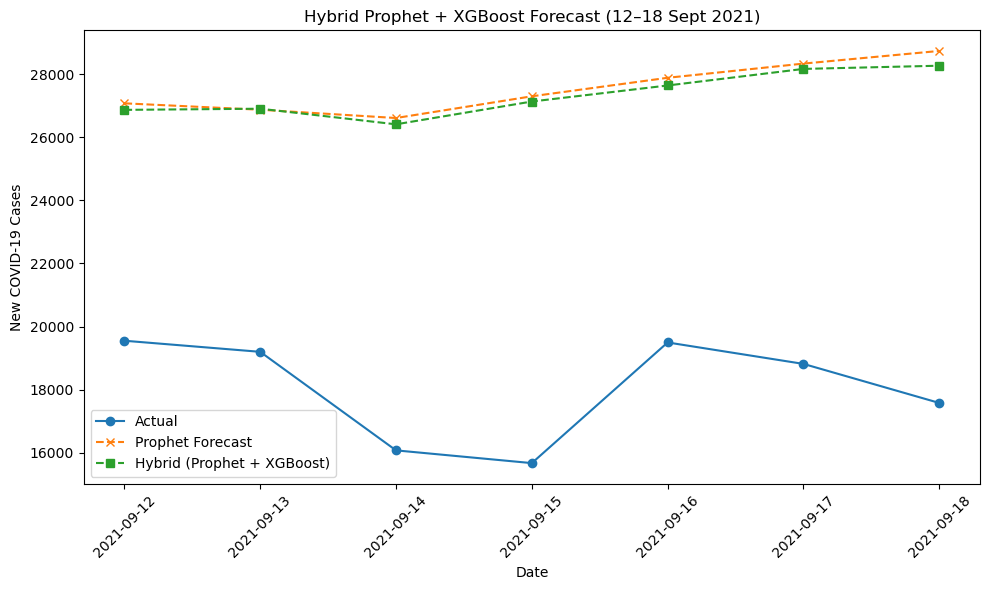

In [31]:
 import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# === Load your data ===
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data['Date'] = pd.to_datetime(data['Date'])
data = data[(data['Date'] >= '2021-01-04') & (data['Date'] <= '2021-09-18')].reset_index(drop=True)

# === Prepare for Prophet ===
df_prophet = data[['Date', 'New COVID-19 Cases']].rename(columns={'Date': 'ds', 'New COVID-19 Cases': 'y'})

# === Split into train and test sets ===
train_end = '2021-08-10'
test_start = '2021-08-11'
test_end = '2021-09-18'

train_df = df_prophet[df_prophet['ds'] <= train_end].copy()
test_df = df_prophet[(df_prophet['ds'] >= test_start) & (df_prophet['ds'] <= test_end)].copy()

# === Step 1: Fit Prophet model ===
model = Prophet(daily_seasonality=True)
model.fit(train_df)

future = model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = model.predict(future)

# === Step 2: Calculate residuals from training data ===
train_pred = forecast[['ds', 'yhat']].iloc[:len(train_df)].reset_index(drop=True)
train_df = train_df.reset_index(drop=True)
train_df['residual'] = train_df['y'] - train_pred['yhat']

# === Step 3: Create lag features for XGBoost ===
lags = 3
for i in range(1, lags + 1):
    train_df[f'lag{i}'] = train_df['residual'].shift(i)

train_df.dropna(inplace=True)

X_train = train_df[[f'lag{i}' for i in range(1, lags + 1)]]
y_train = train_df['residual']

# === Step 4: Train XGBoost on residuals ===
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb.fit(X_train, y_train)

# === Step 5: Predict residuals for test period ===
last_known = train_df[['residual'] + [f'lag{i}' for i in range(1, lags + 1)]].iloc[-1]
lag_values = [last_known[f'lag{i}'] for i in range(1, lags + 1)]
predicted_residuals = []

for _ in range(len(test_df)):
    x_input = np.array(lag_values).reshape(1, -1)
    pred_resid = model_xgb.predict(x_input)[0]
    predicted_residuals.append(pred_resid)

    # update lag values
    lag_values = lag_values[1:] + [pred_resid]

# === Step 6: Combine with Prophet forecast ===
prophet_forecast = forecast['yhat'].iloc[-len(test_df):].values
hybrid_forecast = prophet_forecast + np.array(predicted_residuals)
actual = test_df['y'].values

# === Step 7: Evaluation ===
mse = mean_squared_error(actual, hybrid_forecast)
mae = mean_absolute_error(actual, hybrid_forecast)
mape = np.mean(np.abs((actual - hybrid_forecast) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, hybrid_forecast)


print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# === Step 8: Plot results ===
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], actual, label='Actual')
plt.plot(test_df['ds'], prophet_forecast, label='Prophet Forecast')
plt.plot(test_df['ds'], hybrid_forecast, label='Hybrid Forecast (Prophet + XGBoost)', linestyle='--')
plt.title('Hybrid Forecast: Prophet + XGBoost')
plt.xlabel('Date')
plt.ylabel('New COVID-19 Cases')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
# === Step 9: Extract forecast for 12–18 Sept 2021 ===
forecast_horizon = pd.date_range(start="2021-09-12", end="2021-09-18")

results_df = pd.DataFrame({
    "Date": test_df['ds'].values,
    "Actual": actual,
    "Prophet": prophet_forecast,
    "Hybrid_Forecast": hybrid_forecast
})

# Filter only 12–18 Sept 2021
results_subset = results_df[results_df["Date"].isin(forecast_horizon)]

print("\n📈 Hybrid Prophet + XGBoost Forecast (12–18 Sept 2021):")
print(results_subset)

# === Plot only 12–18 Sept 2021 ===
plt.figure(figsize=(10, 6))
plt.plot(results_subset["Date"], results_subset["Actual"], marker='o', label="Actual")
plt.plot(results_subset["Date"], results_subset["Prophet"], marker='x', linestyle="--", label="Prophet Forecast")
plt.plot(results_subset["Date"], results_subset["Hybrid_Forecast"], marker='s', linestyle="--", label="Hybrid (Prophet + XGBoost)")
plt.title("Hybrid Prophet + XGBoost Forecast (12–18 Sept 2021)")
plt.xlabel("Date")
plt.ylabel("New COVID-19 Cases")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


E:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
E:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
16:16:11 - cmdstanpy - INFO - Chain [1] start processing
16:16:12 - cmdstanpy - INFO - Chain [1] done processing



📊 Final Hybrid ARIMA+Prophet Forecast Evaluation:
Mean Squared Error (MSE): 211943593.70
Mean Absolute Error (MAE): 8924.45
Mean Absolute Percentage Error (MAPE): 48.56%
Root Mean Squared Error (RMSE): 14558.28
Relative RMSE (RRMSE): 0.7846
Normalized RMSE (NRMSE): 0.8679
R-squared (R²): -8.2229

Forecast (12/09/2021 → 18/09/2021):
         Date  Actual     ARIMA_Pred  Prophet_Pred   Hybrid_Pred
32 2021-09-12   19550   88601.207355  11571.213135  50086.210245
33 2021-09-13   19198   91292.851725  11246.268403  51269.560064
34 2021-09-14   16073   94033.492718  10942.599693  52488.046205
35 2021-09-15   15669   96835.577848  11250.168496  54042.873172
36 2021-09-16   19495   99741.952606  11622.051760  55682.002183
37 2021-09-17   18815  102711.059294  11779.284809  57245.172052
38 2021-09-18   17577  105772.668780  12000.899177  58886.783978


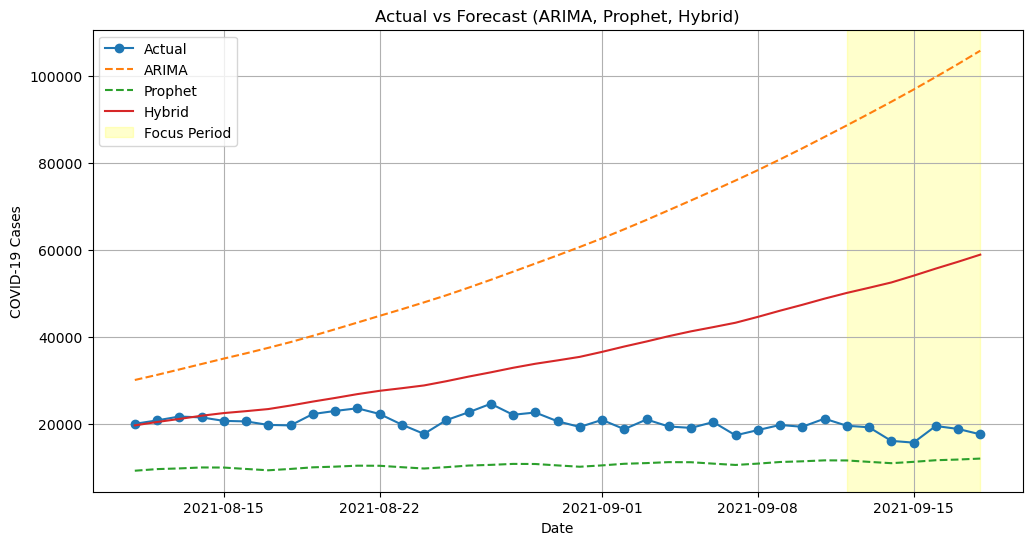

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ================================
# 1. Load and prepare the dataset
# ================================
df = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")

# Ensure proper column names
df.rename(columns={"Date": "ds", "New COVID-19 Cases": "y"}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values("ds")

# ================================
# 2. Train/Validation/Test Split
# ================================
train = df[(df['ds'] >= "2021-01-04") & (df['ds'] <= "2021-07-02")]
val   = df[(df['ds'] >= "2021-07-03") & (df['ds'] <= "2021-08-10")]
test  = df[(df['ds'] >= "2021-08-11") & (df['ds'] <= "2021-09-18")]

y_train, y_val, y_test = train['y'], val['y'], test['y']

# ================================
# 3. ARIMA Model
# ================================
arima_model = ARIMA(y_train, order=(7,4,6))  # tune p,d,q as needed
arima_fit = arima_model.fit()

# Forecast including validation + test
arima_forecast = arima_fit.predict(start=len(y_train), 
                                   end=len(y_train)+len(y_val)+len(y_test)-1)

# ================================
# 4. Prophet Model
# ================================
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(train)

future = prophet_model.make_future_dataframe(periods=len(val)+len(test))
prophet_forecast = prophet_model.predict(future)
prophet_pred = prophet_forecast.iloc[-(len(val)+len(test)):, :]["yhat"].values

# ================================
# 5. Hybrid Forecast (Average)
# ================================
hybrid_forecast = (arima_forecast.values + prophet_pred) / 2

# Align with actual test data
actual = pd.concat([y_val, y_test]).reset_index(drop=True)
preds = pd.Series(hybrid_forecast, index=actual.index)

# ================================
# 6. Error Metrics
# ================================
mse = mean_squared_error(actual, hybrid_forecast)
mae = mean_absolute_error(actual, hybrid_forecast)
mape = np.mean(np.abs((actual - hybrid_forecast) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, hybrid_forecast)

print("\n📊 Final Hybrid ARIMA+Prophet Forecast Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# ================================
# 7. Forecast for 12/09/21 → 18/09/21
# ================================
# ARIMA rolling forecast for test set
arima_pred_test = arima_fit.predict(start=len(y_train)+len(y_val), 
                                    end=len(y_train)+len(y_val)+len(y_test)-1)

# Prophet forecast already includes test
prophet_test_pred = prophet_pred[-len(y_test):]

# Hybrid for test period
hybrid_test_pred = (arima_pred_test.values + prophet_test_pred) / 2

# Match only 12–18 Sep 2021
forecast_df = pd.DataFrame({
    "Date": test['ds'].values,
    "Actual": test['y'].values,
    "ARIMA_Pred": arima_pred_test.values,
    "Prophet_Pred": prophet_test_pred,
    "Hybrid_Pred": hybrid_test_pred
})

forecast_df = forecast_df[(forecast_df["Date"] >= "2021-09-12") & 
                          (forecast_df["Date"] <= "2021-09-18")]

print("\nForecast (12/09/2021 → 18/09/2021):")
print(forecast_df)

# ================================
# 8. Plotting
# ================================
plt.figure(figsize=(12,6))
plt.plot(test['ds'], test['y'], label="Actual", marker="o")
plt.plot(test['ds'], arima_pred_test, label="ARIMA", linestyle="--")
plt.plot(test['ds'], prophet_test_pred, label="Prophet", linestyle="--")
plt.plot(test['ds'], hybrid_test_pred, label="Hybrid", linestyle="-")

plt.axvspan(pd.to_datetime("2021-09-12"), pd.to_datetime("2021-09-18"), 
            color="yellow", alpha=0.2, label="Focus Period")

plt.xlabel("Date")
plt.ylabel("COVID-19 Cases")
plt.title("Actual vs Forecast (ARIMA, Prophet, Hybrid)")
plt.legend()
plt.grid(True)
plt.show()


E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
E:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fai

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1837
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0239
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0160
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0131
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0156
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0151
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0126
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0133
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0179
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0131
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0134
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0136
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0160
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0129
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0156
Epoch 16/50
1

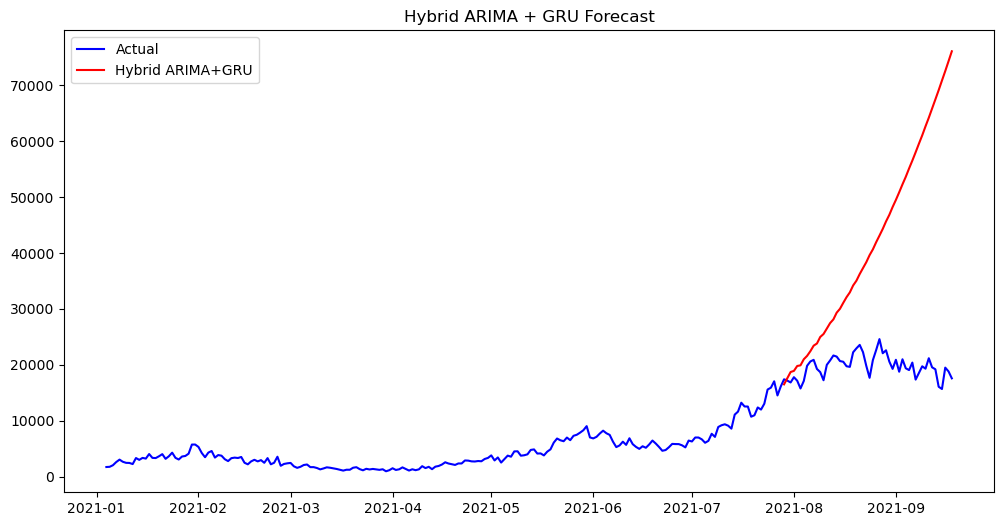


📌 Forecast (12/09/2021 → 18/09/2021):
         Date   Actual   Hybrid_Pred
45 2021-09-12  19550.0  65868.210307
46 2021-09-13  19198.0  67505.620876
47 2021-09-14  16073.0  69158.747031
48 2021-09-15  15669.0  70879.154128
49 2021-09-16  19495.0  72578.025463
50 2021-09-17  18815.0  74341.656200
51 2021-09-18  17577.0  76121.433456


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

# -------------------------------
# 1. Load your data
# -------------------------------
df = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

series = df['New COVID-19 Cases'].astype(float)

# -------------------------------
# 2. Train-Test Split
# -------------------------------
train_size = int(len(series) * 0.8)
train, test = series.iloc[:train_size], series.iloc[train_size:]

# -------------------------------
# 3. Fit ARIMA model
# -------------------------------
arima_order = (7, 4, 6)   # can be tuned
arima_model = ARIMA(train, order=arima_order)
arima_fit = arima_model.fit()

# Predict with ARIMA
arima_pred = arima_fit.predict(start=len(train), end=len(train)+len(test)-1)

# -------------------------------
# 4. Compute residuals
# -------------------------------
residuals = train - arima_fit.fittedvalues
residuals = residuals.dropna()

# -------------------------------
# 5. Prepare residuals for GRU
# -------------------------------
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))

def create_sequences(data, timesteps=5):
    X, y = [], []
    for i in range(len(data)-timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)

timesteps = 5
X, y = create_sequences(residuals_scaled, timesteps)
X = X.reshape((X.shape[0], X.shape[1], 1))

# -------------------------------
# 6. Build GRU model
# -------------------------------
gru_model = Sequential([
    GRU(64, input_shape=(timesteps,1), return_sequences=False),
    Dense(1)
])
gru_model.compile(optimizer=Adam(0.001), loss='mse')

gru_model.fit(X, y, epochs=50, batch_size=16, verbose=1)

# -------------------------------
# 7. Forecast residuals with GRU
# -------------------------------
test_residuals = []
last_sequence = residuals_scaled[-timesteps:]

for i in range(len(test)):
    seq_input = last_sequence.reshape((1, timesteps, 1))
    pred_res = gru_model.predict(seq_input, verbose=0)
    test_residuals.append(pred_res[0,0])
    last_sequence = np.append(last_sequence[1:], pred_res[0,0])
    
test_residuals = scaler.inverse_transform(np.array(test_residuals).reshape(-1,1)).flatten()

# -------------------------------
# 8. Hybrid Forecast
# -------------------------------
hybrid_pred = arima_pred.values + test_residuals

# -------------------------------
# 9. Evaluation
# -------------------------------
mse = mean_squared_error(actual, hybrid_forecast)
mae = mean_absolute_error(actual, hybrid_forecast)
mape = np.mean(np.abs((actual - hybrid_forecast) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, hybrid_forecast)

print("\n📊 Final Hybrid ARIMA-GRU Forecast Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# -------------------------------
# 10. Visualization
# -------------------------------
plt.figure(figsize=(12,6))
plt.plot(series.index, series, label="Actual", color='blue')
plt.plot(test.index, hybrid_pred, label="Hybrid ARIMA+GRU", color='red')
plt.legend()
plt.title("Hybrid ARIMA + GRU Forecast")
plt.show()

# -------------------------------
# 11. Forecast for 12/09/2021 → 18/09/2021
# -------------------------------
# 11. Forecast for 12/09/2021 → 18/09/2021
# -------------------------------
# -------------------------------
# 11. Forecast for 12/09/2021 → 18/09/2021
# -------------------------------
forecast_df = pd.DataFrame({
    "Date": test.index,
    "Actual": test.values,
       # residual forecast (can be shown separately)
    "Hybrid_Pred": hybrid_pred      # ARIMA + GRU
}).reset_index(drop=True)

# Filter only 12–18 Sep 2021
forecast_df = forecast_df[(forecast_df["Date"] >= "2021-09-12") & (forecast_df["Date"] <= "2021-09-18")]

print("\n📌 Forecast (12/09/2021 → 18/09/2021):")
print(forecast_df)



E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
E:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fai

                               SARIMAX Results                                
Dep. Variable:     New COVID-19 Cases   No. Observations:                  219
Model:                 ARIMA(7, 4, 6)   Log Likelihood               -1732.275
Date:                Fri, 26 Sep 2025   AIC                           3492.551
Time:                        16:12:35   BIC                           3539.740
Sample:                    01-04-2021   HQIC                          3511.617
                         - 08-10-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8824      0.341     -5.524      0.000      -2.550      -1.214
ar.L2         -1.0699      0.734     -1.458      0.145      -2.508       0.368
ar.L3         -0.6145      0.566     -1.086      0.2

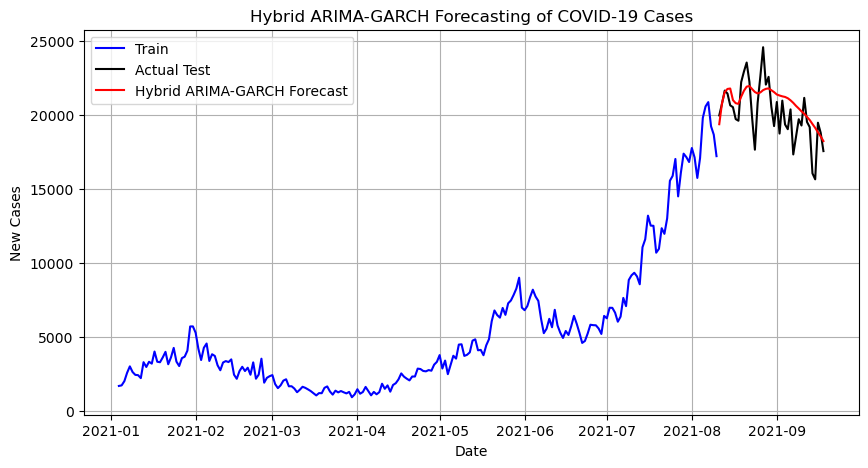

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==============================
# Step 1: Load & preprocess data
# ==============================
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx", 
                     parse_dates=['Date'], index_col='Date')

# Target time series
series = data['New COVID-19 Cases']

# Train-test split
train = series['2021-01-04':'2021-08-10']
test = series['2021-08-11':'2021-09-18']

# ==============================
# Step 2: Fit ARIMA model
# ==============================
arima_model = ARIMA(train, order=(7,4,6))
arima_fit = arima_model.fit()
print(arima_fit.summary())

# Residuals
residuals = arima_fit.resid

# ==============================
# Step 3: Fit GARCH on residuals
# ==============================
garch = arch_model(residuals, vol='GARCH', p=7, q=6)
garch_fit = garch.fit(disp="off")
print(garch_fit.summary())

# ==============================
# Step 4: Forecast
# ==============================
# ARIMA forecast
arima_forecast = arima_fit.forecast(steps=len(test))

# GARCH forecast (step-wise volatility)
garch_forecast = garch_fit.forecast(horizon=len(test))
garch_vol_series = np.sqrt(garch_forecast.variance.values[-1, :])  # std dev for each step

# Hybrid forecast = ARIMA forecast + volatility adjustment
hybrid_forecast = arima_forecast + garch_vol_series
hybrid_forecast = pd.Series(hybrid_forecast, index=test.index)

# ==============================
# Step 5: Evaluation
# ==============================
actual = test  # define actual values

mse = mean_squared_error(actual, hybrid_forecast)
mae = mean_absolute_error(actual, hybrid_forecast)
mape = np.mean(np.abs((actual - hybrid_forecast) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, hybrid_forecast)

print("\n📊 Final Hybrid ARIMA-GARCH Forecast Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# ==============================
# Step 6: Plot
# ==============================
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label="Train", color="blue")
plt.plot(test.index, test, label="Actual Test", color="black")
plt.plot(hybrid_forecast.index, hybrid_forecast, 
         label="Hybrid ARIMA-GARCH Forecast", color="red")

plt.title("Hybrid ARIMA-GARCH Forecasting of COVID-19 Cases")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.show()


Hybrid ARIMA-GARCH Forecast (12–18 Sept 2021):
Date
2021-09-12    19889.023368
2021-09-13    19679.098400
2021-09-14    19408.358304
2021-09-15    19148.447731
2021-09-16    18846.563228
2021-09-17    18567.550940
2021-09-18    18254.412532
Name: predicted_mean, dtype: float64


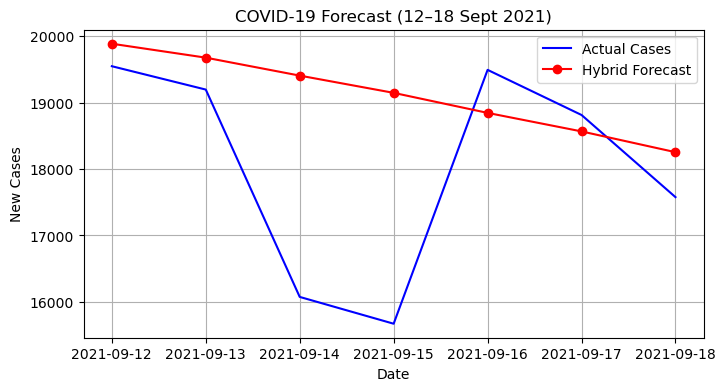

In [17]:
# Select forecast window
forecast_window = hybrid_forecast['2021-09-12':'2021-09-18']
actual_window = test['2021-09-12':'2021-09-18']

print("Hybrid ARIMA-GARCH Forecast (12–18 Sept 2021):")
print(forecast_window)

# Plot actual vs forecast for just that window
plt.figure(figsize=(8,4))
plt.plot(actual_window.index, actual_window, label="Actual Cases", color="blue")
plt.plot(forecast_window.index, forecast_window, label="Hybrid Forecast", color="red", marker='o')

plt.title("COVID-19 Forecast (12–18 Sept 2021)")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.show()


E:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
E:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Hybrid ARIMA-XGBoost Forecast Evaluation:
Mean Squared Error (MSE): 2684182.80
Mean Absolute Error (MAE): 1365.40
Mean Absolute Percentage Error (MAPE): 6.73%
Root Mean Squared Error (RMSE): 1638.35
Relative RMSE (RRMSE): 0.1835
Normalized RMSE (NRMSE): 0.0811
R-squared (R²): 0.2582


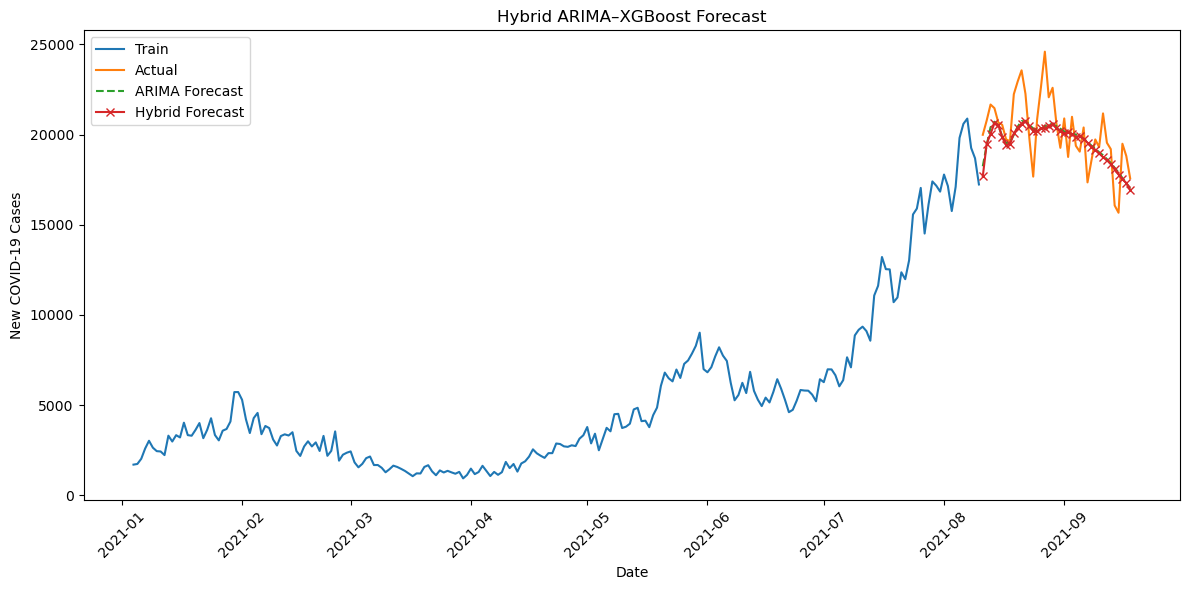


📌 Hybrid ARIMA–XGBoost Forecast (12–18 Sept 2021):
          Date  Actual  ARIMA_Forecast  Hybrid_Forecast
251 2021-09-12   19550    18642.236148     18581.642604
252 2021-09-13   19198    18431.301359     18360.123258
253 2021-09-14   16073    18158.849483     18066.719653
254 2021-09-15   15669    17898.255054     17788.567470
255 2021-09-16   19495    17595.112741     17541.034143
256 2021-09-17   18815    17315.029731     17322.356200
257 2021-09-18   17577    17000.617639     16923.698915


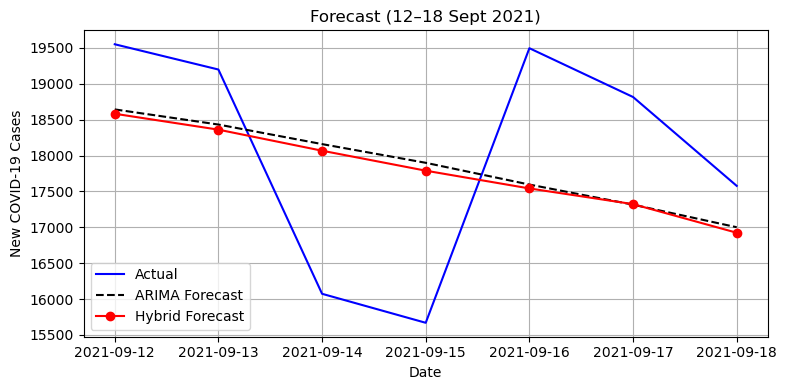

In [18]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# === Load your data ===
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data = data.rename(columns={'New COVID-19 Cases': 'y'})
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

# === Train/Validation/Test split ===
train_end = '2021-08-10'
test_start = '2021-08-11'
test_end = '2021-09-18'

train_data = data[(data['Date'] <= train_end)]
test_data = data[(data['Date'] >= test_start) & (data['Date'] <= test_end)]

# === Step 1: ARIMA model ===
arima_model = ARIMA(train_data['y'], order=(7,4,6))  # adjust (p,d,q)
arima_fit = arima_model.fit()

# Forecast ARIMA on test period
arima_forecast = arima_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False)

# Compute residuals (train)
arima_fitted = arima_fit.fittedvalues
residuals = train_data['y'] - arima_fitted

# === Step 2: Train XGBoost on residuals ===
# Create lag features
def create_lags(series, lags=[1,2,3,7,14]):
    df = pd.DataFrame({'resid': series})
    for lag in lags:
        df[f'lag_{lag}'] = df['resid'].shift(lag)
    return df.dropna()

lags = [1,2,3,7,14]
resid_lags = create_lags(residuals, lags=lags)

X_resid = resid_lags.drop('resid', axis=1)
y_resid = resid_lags['resid']

# Train XGBoost
xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb.fit(X_resid, y_resid)

# === Step 3: Forecast residuals on test set ===
# Build lagged residuals from ARIMA forecast errors (recursive prediction)
test_resid_preds = []
prev_resids = list(residuals[-max(lags):])  # last known residuals

for _ in range(len(test_data)):
    # Build input vector
    input_feats = [prev_resids[-lag] for lag in lags]
    input_df = pd.DataFrame([input_feats], columns=[f'lag_{lag}' for lag in lags])
    
    # Predict next residual
    next_resid = xgb.predict(input_df)[0]
    test_resid_preds.append(next_resid)
    
    # Append for recursive usage
    prev_resids.append(next_resid)

# === Step 4: Hybrid Forecast ===
hybrid_forecast = arima_forecast.values + np.array(test_resid_preds)

# === Evaluation ===
# === Evaluation (Hybrid Forecast vs Actual) ===
y_true = test_data['y'].values
forecast = hybrid_forecast  # rename for clarity

mse = mean_squared_error(y_true, forecast)
mae = mean_absolute_error(y_true, forecast)
mape = np.mean(np.abs((y_true - forecast) / y_true)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(y_true) - np.min(y_true))   # relative to range
nrmse = rmse / np.mean(y_true)                     # relative to mean
r2 = r2_score(y_true, forecast)

# Print results
print("\nHybrid ARIMA-XGBoost Forecast Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


# === Plot Actual vs Forecast ===
plt.figure(figsize=(12,6))
plt.plot(train_data['Date'], train_data['y'], label="Train")
plt.plot(test_data['Date'], y_true, label="Actual")
plt.plot(test_data['Date'], arima_forecast, label="ARIMA Forecast", linestyle="--")
plt.plot(test_data['Date'], hybrid_forecast, label="Hybrid Forecast", marker='x')
plt.legend()
plt.xlabel("Date")
plt.ylabel("New COVID-19 Cases")
plt.title("Hybrid ARIMA–XGBoost Forecast")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# ==============================
# Forecast window: 12/09/2021 → 18/09/2021
# ==============================
forecast_df = pd.DataFrame({
    "Date": test_data['Date'].values,
    "Actual": y_true,
    "ARIMA_Forecast": arima_forecast,
    "Hybrid_Forecast": hybrid_forecast
})

# Select only 12–18 Sept 2021
mask = (forecast_df['Date'] >= "2021-09-12") & (forecast_df['Date'] <= "2021-09-18")
forecast_window = forecast_df.loc[mask]

print("\n📌 Hybrid ARIMA–XGBoost Forecast (12–18 Sept 2021):")
print(forecast_window)

# Plot zoomed window
plt.figure(figsize=(8,4))
plt.plot(forecast_window['Date'], forecast_window['Actual'], label="Actual", color="blue")
plt.plot(forecast_window['Date'], forecast_window['ARIMA_Forecast'], 
         label="ARIMA Forecast", linestyle="--", color="black")
plt.plot(forecast_window['Date'], forecast_window['Hybrid_Forecast'], 
         label="Hybrid Forecast", marker="o", color="red")
plt.legend()
plt.xlabel("Date")
plt.ylabel("New COVID-19 Cases")
plt.title("Forecast (12–18 Sept 2021)")
plt.grid(True)
plt.tight_layout()
plt.show()


E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
E:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fai

Hybrid ARIMA–SVR Performance:
MSE: 2545473.04
MAE: 1315.66
MAPE: 6.50%
RMSE: 1595.45
RRMSE: 0.1787
NRMSE: 0.0790
R²: 0.2965


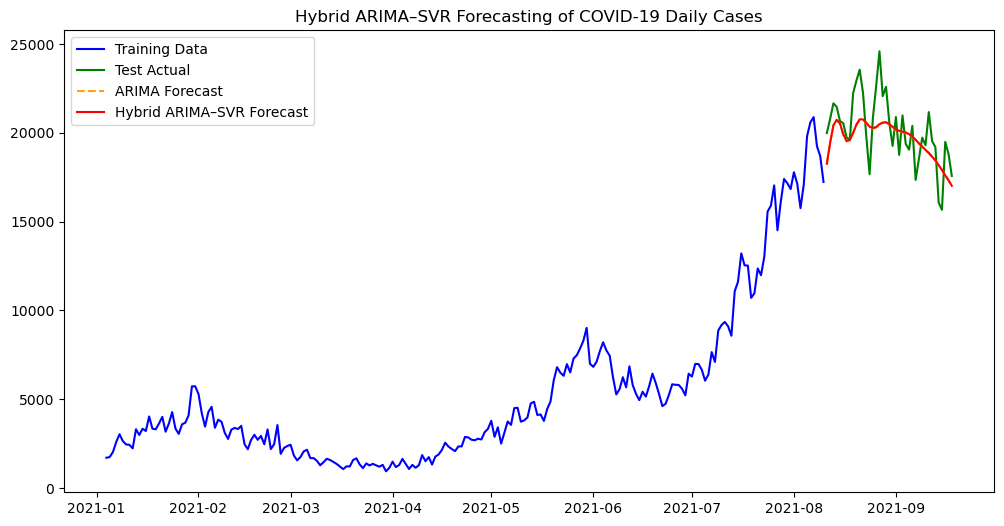

Hybrid ARIMA–SVR Forecast (12–18 Sept 2021):
2021-09-12    18662.899011
2021-09-13    18451.964222
2021-09-14    18179.512346
2021-09-15    17918.917917
2021-09-16    17615.775604
2021-09-17    17335.692594
2021-09-18    17021.280502
Freq: D, dtype: float64


In [22]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# === Step 1: Load and preprocess data ===
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data_filtered = data[(data['Date'] >= '2021-01-04') & (data['Date'] <= '2021-09-18')].reset_index(drop=True)

# Set time series
covid_cases_ts = data_filtered.set_index('Date')['New COVID-19 Cases']

# === Step 2: Train ARIMA model (linear component) ===
train_series = covid_cases_ts['2021-01-04':'2021-08-10']  # train+val
test_series = covid_cases_ts['2021-08-11':'2021-09-18']

arima_model = ARIMA(train_series, order=(7,4,6))  # Example order
arima_fit = arima_model.fit()

# In-sample fitted values
arima_fitted = arima_fit.fittedvalues
residuals = train_series - arima_fitted

# === Step 3: Prepare residuals for SVR (nonlinear component) ===
# Explicitly name the residuals column
residuals_df = pd.DataFrame(residuals, columns=["residuals"])

# Create lag features
for lag in range(1, 8):  # last 7 lags
    residuals_df[f"lag_{lag}"] = residuals_df["residuals"].shift(lag)

residuals_df = residuals_df.dropna()

# Features & target for SVR
X_res = residuals_df.drop(columns=["residuals"]).values
y_res = residuals_df["residuals"].values

# Scale features
scaler = MinMaxScaler()
X_res = scaler.fit_transform(X_res)

# Train SVR
svr_model = SVR(kernel="rbf", C=100, gamma=0.01, epsilon=50)
svr_model.fit(X_res, y_res)

# === Step 4: Forecast with ARIMA + SVR ===
arima_forecast = arima_fit.forecast(steps=len(test_series))

# Build SVR input for test period residual prediction
resid_values = residuals.tolist()
svr_preds = []

for i in range(len(test_series)):
    last_lags = np.array(resid_values[-7:]).reshape(1, -1)  # last 7 residuals
    last_lags_scaled = scaler.transform(last_lags)
    svr_pred = svr_model.predict(last_lags_scaled)[0]
    svr_preds.append(svr_pred)
    resid_values.append(svr_pred)  # update with predicted residual

svr_preds = pd.Series(svr_preds, index=test_series.index)

# Hybrid forecast = ARIMA forecast + SVR residual forecast
hybrid_forecast = arima_forecast + svr_preds

# === Step 5: Evaluate ===
mse = mean_squared_error(test_series, hybrid_forecast)
mae = mean_absolute_error(test_series, hybrid_forecast)
mape = np.mean(np.abs((test_series - hybrid_forecast) / test_series)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(test_series) - np.min(test_series))
nrmse = rmse / np.mean(test_series)
r2 = r2_score(test_series, hybrid_forecast)

print("Hybrid ARIMA–SVR Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"R²: {r2:.4f}")

# === Step 6: Plot results ===
plt.figure(figsize=(12,6))
plt.plot(train_series.index, train_series, label="Training Data", color="blue")
plt.plot(test_series.index, test_series, label="Test Actual", color="green")
plt.plot(test_series.index, arima_forecast, label="ARIMA Forecast", color="orange", linestyle="--")
plt.plot(test_series.index, hybrid_forecast, label="Hybrid ARIMA–SVR Forecast", color="red")
plt.legend()
plt.title("Hybrid ARIMA–SVR Forecasting of COVID-19 Daily Cases")
plt.show()
# Extract forecasts from 12 Sept 2021 to 18 Sept 2021
forecast_period = hybrid_forecast['2021-09-12':'2021-09-18']
print("Hybrid ARIMA–SVR Forecast (12–18 Sept 2021):")
print(forecast_period)


17:24:46 - cmdstanpy - INFO - Chain [1] start processing
17:24:46 - cmdstanpy - INFO - Chain [1] done processing


Hybrid prophet–SVR Performance:
MSE: 50603688.68
MAE: 6250.20
MAPE: 30.26%
RMSE: 7113.63
RRMSE: 0.7966
NRMSE: 0.3523
R²: -12.9851

Hybrid Forecast (12–18 Sept 2021):
            ds      y  Hybrid_Forecast
251 2021-09-12  19550     15186.629889
252 2021-09-13  19198     15412.545807
253 2021-09-14  16073     15526.585213
254 2021-09-15  15669     16571.980393
255 2021-09-16  19495     17467.747823
256 2021-09-17  18815     18207.659299
257 2021-09-18  17577     18835.699186


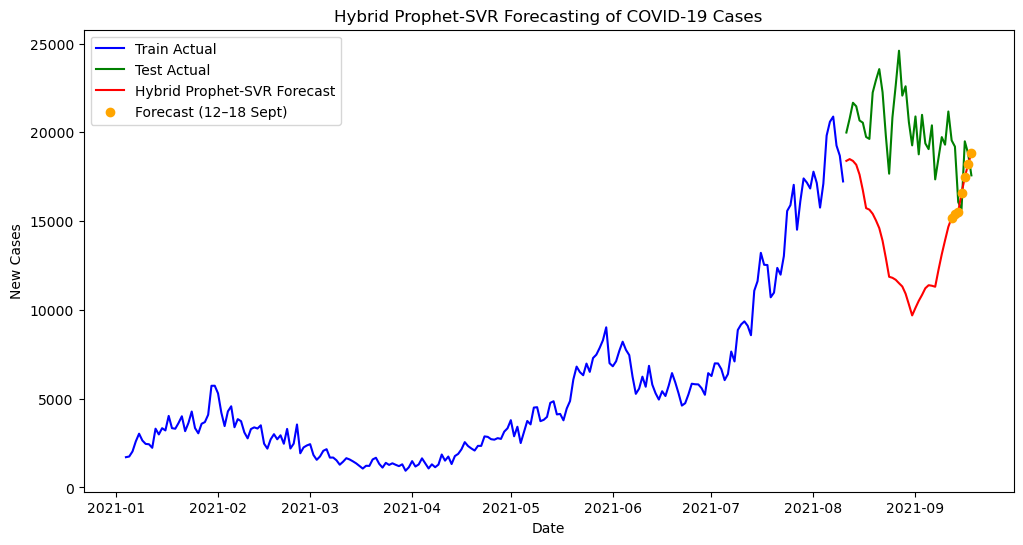

In [23]:
# =========================
# Prophet + SVR Hybrid Model with Forecasting for 12–18 Sept 2021
# =========================

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# =========================
# 1. Load and preprocess data
# =========================
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")

# Rename columns to Prophet format
data["Date"] = pd.to_datetime(data["Date"])
data = data.rename(columns={"Date": "ds", "New COVID-19 Cases": "y"})

# =========================
# 2. Train/Test split
# =========================
train = data[data["ds"] <= "2021-08-10"]   # Train until Aug 10, 2021
test  = data[data["ds"] > "2021-08-10"]    # Test from Aug 11, 2021 onward

# =========================
# 3. Fit Prophet model
# =========================
prophet = Prophet(daily_seasonality=True, yearly_seasonality=True)
prophet.fit(train)

# Forecast over the whole dataset length
future = prophet.make_future_dataframe(periods=len(test), freq="D")
prophet_forecast = prophet.predict(future)

# Align Prophet forecast with actual data
prophet_pred = prophet_forecast.set_index("ds").loc[data["ds"], "yhat"].values

# =========================
# 4. Compute residuals (Actual - Prophet)
# =========================
residuals = data["y"].values - prophet_pred
residuals_df = pd.DataFrame({"ds": data["ds"], "residuals": residuals})

# =========================
# 5. SVR on residuals
# =========================
# Create lag features for residuals (last 7 days)
for lag in range(1, 8):
    residuals_df[f"lag_{lag}"] = residuals_df["residuals"].shift(lag)

residuals_df = residuals_df.dropna().reset_index(drop=True)

# Train/Test split (same as before)
train_resid = residuals_df[residuals_df["ds"] <= "2021-08-10"]
test_resid  = residuals_df[residuals_df["ds"] > "2021-08-10"]

X_train = train_resid.drop(columns=["ds", "residuals"]).values
y_train = train_resid["residuals"].values
X_test  = test_resid.drop(columns=["ds", "residuals"]).values
y_test  = test_resid["residuals"].values

# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Train SVR
svr = SVR(kernel="rbf", C=100, gamma=0.01, epsilon=50)
svr.fit(X_train, y_train)

# Predict residuals
resid_pred = svr.predict(X_test)

# =========================
# 6. Hybrid Forecast = Prophet + SVR residual correction
# =========================
hybrid_forecast = prophet_pred[-len(test):] + resid_pred

# =========================
# 7. Evaluation
# =========================
mse = mean_squared_error(test_series, hybrid_forecast)
mae = mean_absolute_error(test_series, hybrid_forecast)
mape = np.mean(np.abs((test_series - hybrid_forecast) / test_series)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(test_series) - np.min(test_series))
nrmse = rmse / np.mean(test_series)
r2 = r2_score(test_series, hybrid_forecast)

print("Hybrid prophet–SVR Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"R²: {r2:.4f}")

# =========================
# 8. Forecast for 12–18 Sept 2021
# =========================
forecast_week = test[(test["ds"] >= "2021-09-12") & (test["ds"] <= "2021-09-18")].copy()
forecast_week["Hybrid_Forecast"] = hybrid_forecast[-len(forecast_week):]

print("\nHybrid Forecast (12–18 Sept 2021):")
print(forecast_week[["ds", "y", "Hybrid_Forecast"]])

# =========================
# 9. Plot Results
# =========================
plt.figure(figsize=(12,6))
plt.plot(train["ds"], train["y"], label="Train Actual", color="blue")
plt.plot(test["ds"], test["y"], label="Test Actual", color="green")
plt.plot(test["ds"], hybrid_forecast, label="Hybrid Prophet-SVR Forecast", color="red")

# Highlight 12–18 Sept
plt.scatter(forecast_week["ds"], forecast_week["Hybrid_Forecast"], 
            color="orange", label="Forecast (12–18 Sept)", zorder=5)

plt.legend()
plt.title("Hybrid Prophet-SVR Forecasting of COVID-19 Cases")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.show()


17:26:57 - cmdstanpy - INFO - Chain [1] start processing
17:26:57 - cmdstanpy - INFO - Chain [1] done processing
E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.1161 - val_loss: 0.0091
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0114 - val_loss: 0.0093
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0044 - val_loss: 0.0182
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0041 - val_loss: 0.0099
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - val_loss: 0.0115
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0036 - val_loss: 0.0119
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030 - val_loss: 0.0108
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - val_loss: 0.0120
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - val_loss: 0.0111
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - val_loss: 0.0114
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027 - val_loss: 0.0108
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

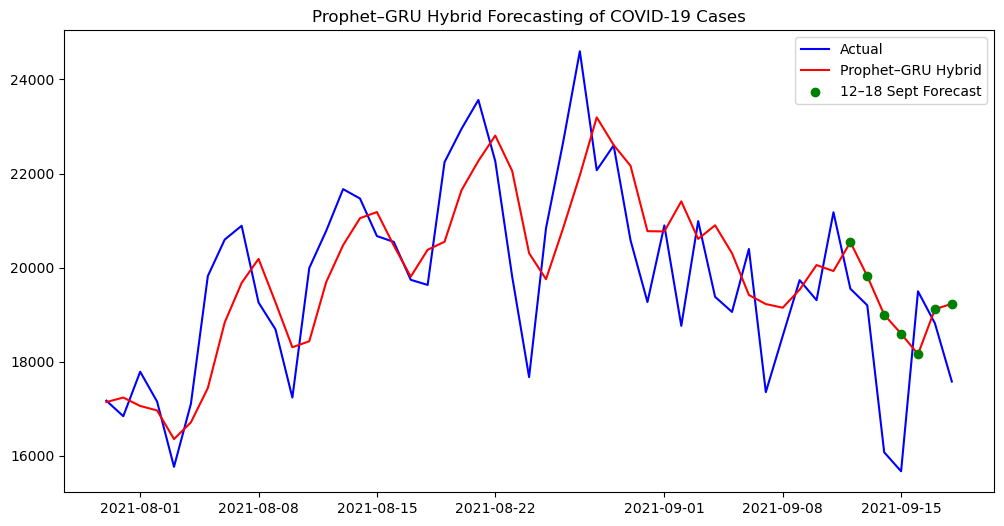

In [25]:
# =========================
# Prophet + GRU Hybrid Model
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================
# 1. Load data
# =========================
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data["Date"] = pd.to_datetime(data["Date"])
data = data.rename(columns={"Date": "ds", "New COVID-19 Cases": "y"})

# =========================
# 2. Fit Prophet
# =========================
prophet = Prophet()
prophet.fit(data)

# Forecast with Prophet (in-sample)
future = prophet.make_future_dataframe(periods=0)
forecast = prophet.predict(future)

# Residuals = Actual - Prophet Prediction
data["prophet_pred"] = forecast["yhat"].values
data["residuals"] = data["y"] - data["prophet_pred"]

# =========================
# 3. Prepare GRU on residuals
# =========================
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(data["residuals"].values.reshape(-1,1))

def create_sequences(data, seq_length=7):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 7
X, y = create_sequences(residuals_scaled, seq_length)

# Split train/test (80/20)
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for GRU [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# =========================
# 4. Build GRU model
# =========================
gru_model = Sequential()
gru_model.add(GRU(64, activation="tanh", input_shape=(seq_length,1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer="adam", loss="mse")

# Train GRU
gru_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# Predict residuals
residuals_pred_scaled = gru_model.predict(X_test)
residuals_pred = scaler.inverse_transform(residuals_pred_scaled)

# Align Prophet predictions with GRU predictions
prophet_test = data["prophet_pred"].values[-len(residuals_pred):].reshape(-1,1)
final_pred = prophet_test + residuals_pred

# Actual values
actual = data["y"].values[-len(residuals_pred):].reshape(-1,1)

# =========================
# 5. Evaluation
# =========================
mse = mean_squared_error(actual, final_pred)
mae = mean_absolute_error(actual, final_pred)
mape = np.mean(np.abs((actual - final_pred) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, final_pred)

print("Hybrid Prophet–GRU Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"R²: {r2:.4f}")

# =========================
# 6. Forecast extraction for 12–18 Sept 2021
# =========================
forecast_period = pd.DataFrame({
    "Date": data["ds"].values[-len(final_pred):],
    "Actual": actual.flatten(),
    "Hybrid_Forecast": final_pred.flatten()
})

week_forecast = forecast_period[
    (forecast_period["Date"] >= "2021-09-12") & 
    (forecast_period["Date"] <= "2021-09-18")
]

print("\nHybrid Prophet–GRU Forecast (12–18 Sept 2021):")
print(week_forecast)

# =========================
# 7. Plot results
# =========================
plt.figure(figsize=(12,6))
plt.plot(data["ds"].values[-len(actual):], actual, label="Actual", color="blue")
plt.plot(data["ds"].values[-len(actual):], final_pred, label="Prophet–GRU Hybrid", color="red")
plt.scatter(week_forecast["Date"], week_forecast["Hybrid_Forecast"], color="green", label="12–18 Sept Forecast", zorder=5)
plt.legend()
plt.title("Prophet–GRU Hybrid Forecasting of COVID-19 Cases")
plt.show()


Epoch 1/50


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.3231 - val_loss: 0.0988
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0890 - val_loss: 0.0302
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0350 - val_loss: 0.0487
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0371 - val_loss: 0.0311
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0300 - val_loss: 0.0302
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0329 - val_loss: 0.0302
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0310 - val_loss: 0.0315
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0354 - val_loss: 0.0323
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0299 - val_loss: 0.0304
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0297 - val_loss: 0.0301
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0320 - val_loss: 0.0313
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0347 - val_loss: 0.0311
Epoch 13/50

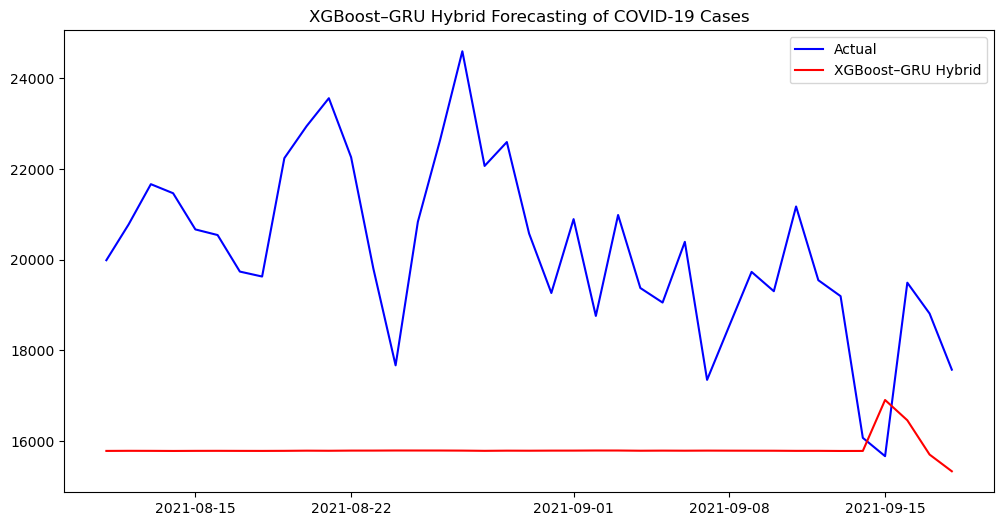


📌 Hybrid XGBoost–GRU Forecast (12–18 Sept 2021):
         Date  Actual  Hybrid_Forecast
32 2021-09-12   19550     15786.579102
33 2021-09-13   19198     15783.865234
34 2021-09-14   16073     15784.363281
35 2021-09-15   15669     16907.992188
36 2021-09-16   19495     16460.464844
37 2021-09-17   18815     15704.688477
38 2021-09-18   17577     15335.809570


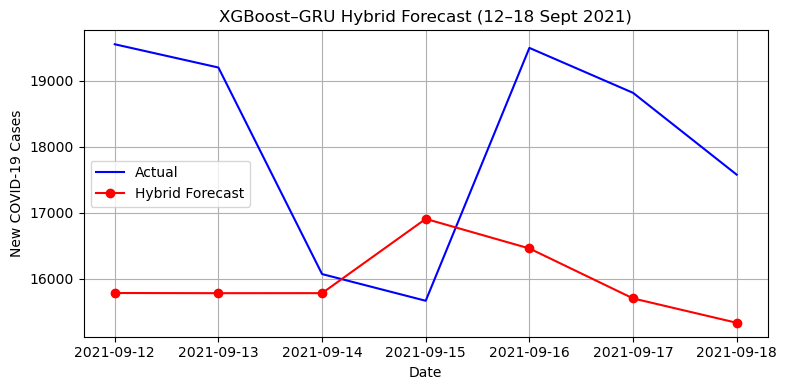

In [27]:
# =========================
# XGBoost + GRU Hybrid Model
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# =========================
# 1. Load data
# =========================
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data["Date"] = pd.to_datetime(data["Date"])
data = data.rename(columns={"Date": "ds", "New COVID-19 Cases": "y"})

# =========================
# 2. Prepare features for XGBoost
# =========================
def create_lag_features(df, col="y", lags=7):
    for lag in range(1, lags+1):
        df[f"lag_{lag}"] = df[col].shift(lag)
    return df

data = create_lag_features(data, "y", lags=7)
data = data.dropna().reset_index(drop=True)

features = [col for col in data.columns if "lag_" in col]
X = data[features].values
y = data["y"].values

# Train/test split
split = int(len(data)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# =========================
# 3. Train XGBoost baseline
# =========================
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

# Train without early stopping (your version doesn’t support it)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# XGBoost predictions
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)

# Residuals
train_resid = y_train - train_pred
test_resid = y_test - test_pred

# =========================
# 4. GRU on residuals
# =========================
scaler = MinMaxScaler()
resid_scaled = scaler.fit_transform(train_resid.reshape(-1,1))

def create_sequences(data, seq_length=7):
    X_seq, y_seq = [], []
    for i in range(len(data)-seq_length):
        X_seq.append(data[i:i+seq_length])
        y_seq.append(data[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 7
X_seq, y_seq = create_sequences(resid_scaled, seq_length)

# Train/test split for GRU
split_gru = int(len(X_seq)*0.8)
X_train_seq, X_test_seq = X_seq[:split_gru], X_seq[split_gru:]
y_train_seq, y_test_seq = y_seq[:split_gru], y_seq[split_gru:]

# Reshape for GRU
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], seq_length, 1))
X_test_seq  = X_test_seq.reshape((X_test_seq.shape[0], seq_length, 1))

# GRU model
gru_model = Sequential()
gru_model.add(GRU(64, activation="tanh", input_shape=(seq_length,1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer="adam", loss="mse")

# Train GRU
gru_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# Predict residuals
resid_pred_scaled = gru_model.predict(X_test_seq)
resid_pred = scaler.inverse_transform(resid_pred_scaled)

# Align lengths
xgb_test_pred = test_pred[-len(resid_pred):]
final_pred = xgb_test_pred + resid_pred.flatten()
actual = y_test[-len(resid_pred):]

# =========================
# 5. Evaluation
# =========================
mse = mean_squared_error(actual, final_pred)
mae = mean_absolute_error(actual, final_pred)
mape = np.mean(np.abs((actual - final_pred) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, final_pred)

print("Hybrid XGBoost–GRU Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"R²: {r2:.4f}")

# =========================
# 6. Plot results
# =========================
plt.figure(figsize=(12,6))
plt.plot(data["ds"].values[-len(actual):], actual, label="Actual", color="blue")
plt.plot(data["ds"].values[-len(final_pred):], final_pred, label="XGBoost–GRU Hybrid", color="red")
plt.legend()
plt.title("XGBoost–GRU Hybrid Forecasting of COVID-19 Cases")
plt.show()
# =========================
# 7. Forecast for 12/09/2021 → 18/09/2021
# =========================
forecast_df = pd.DataFrame({
    "Date": data["ds"].values[-len(actual):],
    "Actual": actual,
    "Hybrid_Forecast": final_pred
})

# Select only 12–18 Sept 2021
mask = (forecast_df["Date"] >= "2021-09-12") & (forecast_df["Date"] <= "2021-09-18")
forecast_window = forecast_df.loc[mask]

print("\n📌 Hybrid XGBoost–GRU Forecast (12–18 Sept 2021):")
print(forecast_window)

# Plot zoomed window
plt.figure(figsize=(8,4))
plt.plot(forecast_window["Date"], forecast_window["Actual"], label="Actual", color="blue")
plt.plot(forecast_window["Date"], forecast_window["Hybrid_Forecast"], 
         label="Hybrid Forecast", marker="o", color="red")
plt.legend()
plt.xlabel("Date")
plt.ylabel("New COVID-19 Cases")
plt.title("XGBoost–GRU Hybrid Forecast (12–18 Sept 2021)")
plt.grid(True)
plt.tight_layout()
plt.show()



Hybrid XGBoost–SVR Performance:
MSE: 19463078.17
MAE: 3942.30
MAPE: 19.17%
RMSE: 4411.70
RRMSE: 0.4940
NRMSE: 0.2237
R²: -3.7932


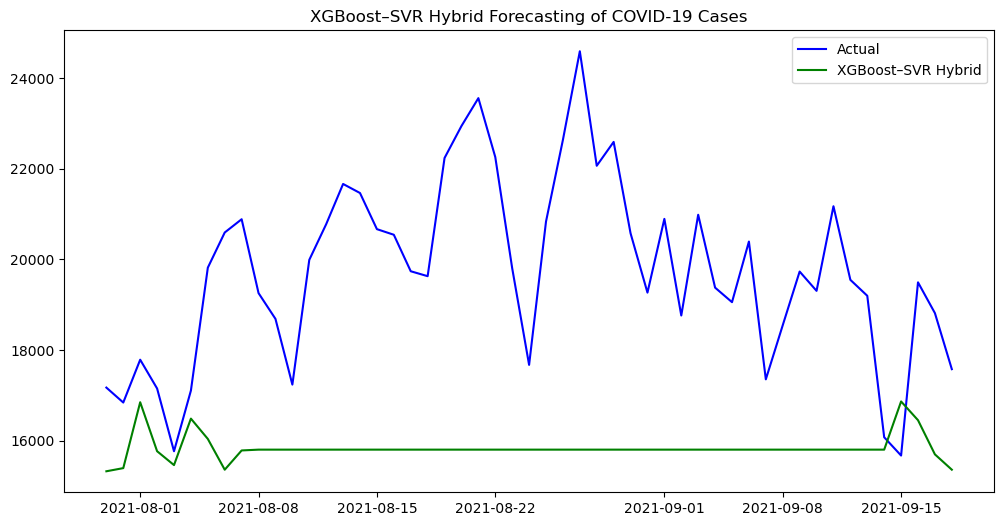


Hybrid XGBoost–SVR Forecast (12–18 Sept 2021):
          ds  Hybrid_XGB_SVR_Forecast
0 2021-09-12             15799.416728
1 2021-09-13             15799.416728
2 2021-09-14             15799.416728
3 2021-09-15             15799.416728
4 2021-09-16             15781.438212
5 2021-09-17             15338.283915
6 2021-09-18             15575.117900


In [18]:
# =========================
# XGBoost + SVR Hybrid Model
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# =========================
# 1. Load data
# =========================
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data["Date"] = pd.to_datetime(data["Date"])
data = data.rename(columns={"Date": "ds", "New COVID-19 Cases": "y"})

# =========================
# 2. Feature engineering (lags for supervised learning)
# =========================
df = data.copy()
for lag in range(1, 8):  # last 7 days as features
    df[f"lag_{lag}"] = df["y"].shift(lag)

df = df.dropna().reset_index(drop=True)

X = df[[f"lag_{i}" for i in range(1, 8)]].values
y = df["y"].values

# Train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# =========================
# 3. Train XGBoost baseline
# =========================
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)

# Residuals
residuals_train = y_train - xgb_train_pred
residuals_test = y_test - xgb_test_pred

# =========================
# 4. Train SVR on residuals
# =========================
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals_train.reshape(-1,1)).ravel()

svr = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr.fit(X_train, residuals_scaled)

# SVR residual predictions (scaled back)
svr_resid_pred_scaled = svr.predict(X_test)
svr_resid_pred = scaler.inverse_transform(svr_resid_pred_scaled.reshape(-1,1)).ravel()

# =========================
# 5. Hybrid forecast = XGBoost + SVR residuals
# =========================
hybrid_pred = xgb_test_pred + svr_resid_pred

# =========================
# 6. Evaluation
# =========================
actual = y_test
final_pred = hybrid_pred

mse = mean_squared_error(actual, final_pred)
mae = mean_absolute_error(actual, final_pred)
mape = np.mean(np.abs((actual - final_pred) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, final_pred)

print("Hybrid XGBoost–SVR Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"R²: {r2:.4f}")

# =========================
# 7. Plot Results
# =========================
plt.figure(figsize=(12,6))
plt.plot(df["ds"].values[train_size:], y_test, label="Actual", color="blue")
plt.plot(df["ds"].values[train_size:], hybrid_pred, label="XGBoost–SVR Hybrid", color="green")
plt.legend()
plt.title("XGBoost–SVR Hybrid Forecasting of COVID-19 Cases")
plt.show()

# =========================
# 8. Forecasting specific period: 12/09/2021 → 18/09/2021
# =========================

# Find the row corresponding to 11 Sept 2021
last_index = df[df['ds'] == '2021-09-11'].index[0]
last_known = df[[f"lag_{i}" for i in range(1, 8)]].iloc[last_index].values.reshape(1, -1)

forecast_dates = pd.date_range(start='2021-09-12', end='2021-09-18')
forecast_days = len(forecast_dates)

hybrid_forecast = []
current_input = last_known.copy()

for i in range(forecast_days):
    # XGBoost prediction
    xgb_pred = xgb_model.predict(current_input)[0]

    # SVR residual prediction
    svr_resid_scaled = svr.predict(current_input)[0]
    svr_resid = scaler.inverse_transform([[svr_resid_scaled]])[0][0]

    # Hybrid prediction
    day_forecast = xgb_pred + svr_resid
    hybrid_forecast.append(day_forecast)

    # Update input for next day (recursive)
    new_input = np.roll(current_input, -1)
    new_input[0, -1] = day_forecast
    current_input = new_input

# Put results into DataFrame
forecast_df = pd.DataFrame({
    "ds": forecast_dates,
    "Hybrid_XGB_SVR_Forecast": hybrid_forecast
})

print("\nHybrid XGBoost–SVR Forecast (12–18 Sept 2021):")
print(forecast_df)


Epoch 1/50


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0387
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0121
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013     
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012    
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012 
Epoch 16/50
13/

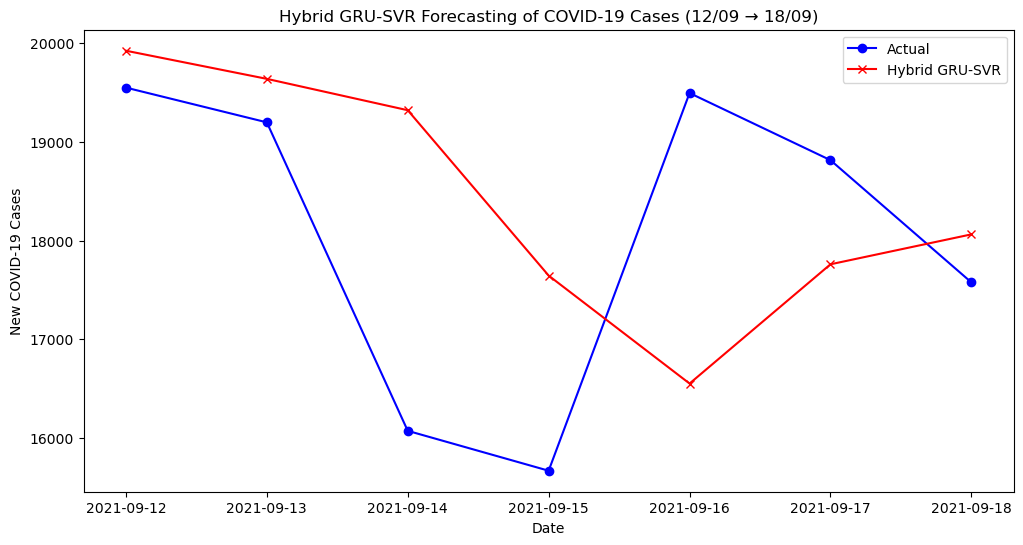

2021-09-12 - Predicted: 19923, Actual: 19550
2021-09-13 - Predicted: 19638, Actual: 19198
2021-09-14 - Predicted: 19320, Actual: 16073
2021-09-15 - Predicted: 17645, Actual: 15669
2021-09-16 - Predicted: 16552, Actual: 19495
2021-09-17 - Predicted: 17760, Actual: 18815
2021-09-18 - Predicted: 18063, Actual: 17577


In [19]:
# =========================
# GRU + SVR Hybrid Model (Forecast 12/09 → 18/09)
# =========================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# =========================
# 1. Load data
# =========================
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data['Date'] = pd.to_datetime(data['Date'])
data = data.rename(columns={"Date": "ds", "New COVID-19 Cases": "y"})

# Normalize target for GRU
scaler = MinMaxScaler()
data['y_scaled'] = scaler.fit_transform(data[['y']])

# =========================
# 2. Prepare sequences for GRU
# =========================
def create_sequences(series, seq_length=7):
    X, y = [], []
    for i in range(len(series) - seq_length):
        X.append(series[i:i+seq_length])
        y.append(series[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 7
X, y = create_sequences(data['y_scaled'].values, seq_length)

# Train/test split
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for GRU [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# =========================
# 3. Build and train GRU
# =========================
gru_model = Sequential()
gru_model.add(GRU(64, activation='tanh', input_shape=(seq_length,1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# GRU predictions
gru_pred_scaled = gru_model.predict(X_test)
gru_pred = scaler.inverse_transform(gru_pred_scaled)

# =========================
# 4. Compute residuals and train SVR
# =========================
residuals = data['y'].values[-len(gru_pred):] - gru_pred.flatten()

# Create lag features for residuals
residuals_df = pd.DataFrame({'residuals': residuals})
for lag in range(1, 8):
    residuals_df[f'lag_{lag}'] = residuals_df['residuals'].shift(lag)
residuals_df = residuals_df.dropna()

X_resid = residuals_df[[f'lag_{i}' for i in range(1, 8)]].values
y_resid = residuals_df['residuals'].values

# Train/test split for SVR
split_idx = int(len(X_resid)*0.8)
X_svr_train, X_svr_test = X_resid[:split_idx], X_resid[split_idx:]
y_svr_train, y_svr_test = y_resid[:split_idx], y_resid[split_idx:]

# Train SVR
svr_model = SVR(kernel='rbf', C=100, gamma=0.01, epsilon=50)
svr_model.fit(X_svr_train, y_svr_train)

# SVR residual predictions
resid_pred = svr_model.predict(X_svr_test)

# =========================
# 5. Hybrid Forecast = GRU + SVR residuals
# =========================
hybrid_forecast = gru_pred[-len(resid_pred):].flatten() + resid_pred

# =========================
# 6. Extract forecast for 12/09 → 18/09
# =========================
forecast_dates = pd.date_range(start='2021-09-12', end='2021-09-18')
# Ensure length matches
hybrid_7days = hybrid_forecast[-7:]
actual_7days = data[data['ds'].between('2021-09-12','2021-09-18')]['y'].values

# =========================
# 7. Evaluation
# =========================
mse = mean_squared_error(actual, final_pred)
mae = mean_absolute_error(actual, final_pred)
mape = np.mean(np.abs((actual - final_pred) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, final_pred)

print("Hybrid SVR–GRU Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"R²: {r2:.4f}")

# =========================
# 8. Plot results
# =========================
plt.figure(figsize=(12,6))
plt.plot(forecast_dates, actual_7days, label='Actual', color='blue', marker='o')
plt.plot(forecast_dates, hybrid_7days, label='Hybrid GRU-SVR', color='red', marker='x')
plt.title('Hybrid GRU-SVR Forecasting of COVID-19 Cases (12/09 → 18/09)')
plt.xlabel('Date')
plt.ylabel('New COVID-19 Cases')
plt.legend()
plt.show()
# 6. Extract forecast for 12/09 → 18/09
# =========================
forecast_dates = pd.date_range(start='2021-09-12', end='2021-09-18')
# Ensure length matches
hybrid_7days = hybrid_forecast[-7:]
actual_7days = data[data['ds'].between('2021-09-12','2021-09-18')]['y'].values
for date, pred, actual in zip(forecast_dates, hybrid_7days, actual_7days):
    print(f"{date.date()} - Predicted: {int(pred)}, Actual: {int(actual)}")

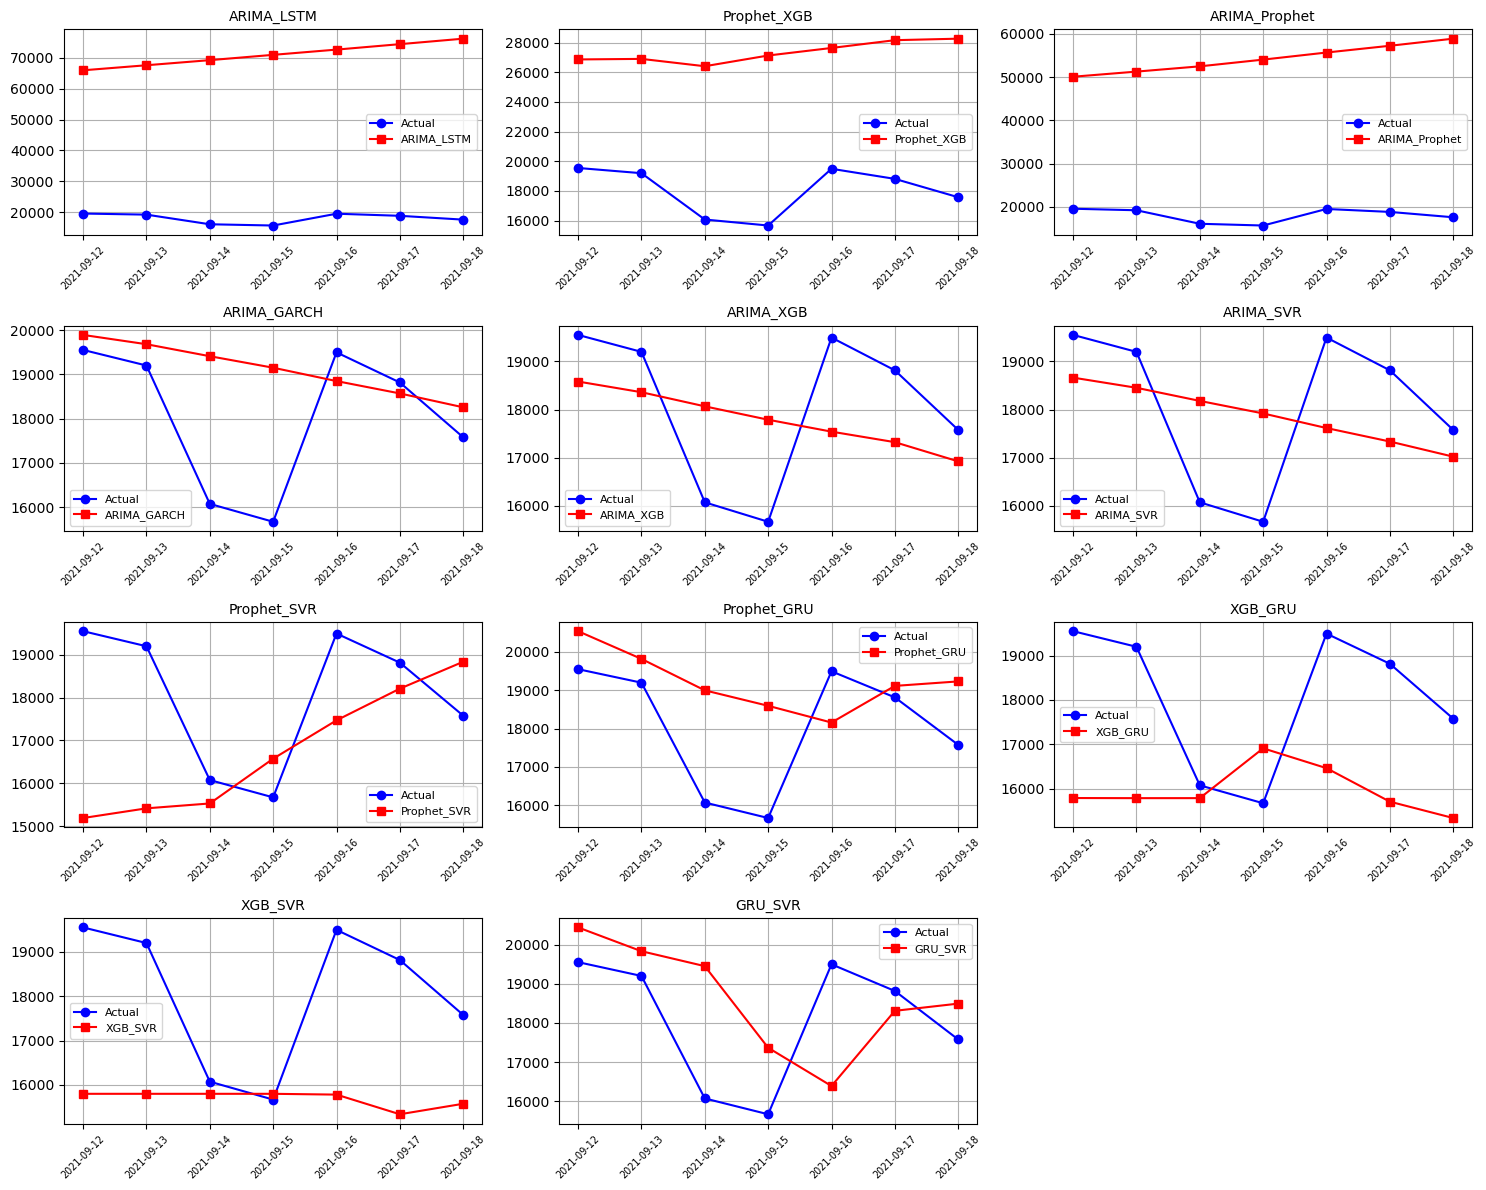

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# ==========================
# Common Actual Values
# ==========================
dates = [
    "2021-09-12","2021-09-13","2021-09-14",
    "2021-09-15","2021-09-16","2021-09-17","2021-09-18"
]
actual = [19550, 19198, 16073, 15669, 19495, 18815, 17577]

# ==========================
# All Hybrid Forecasts
# ==========================
data = {
    "Date": pd.to_datetime(dates),
    "Actual": actual,

    "ARIMA_LSTM":   [65995.885472, 67633.296042, 69286.422196,
                    71006.829293, 72705.700628, 74469.331365, 76249.108622],

    "Prophet_XGB": [26870.635146, 26907.275203, 26412.364582,
                    27135.298217, 27643.897871, 28169.212570, 28270.900755],

    "ARIMA_Prophet": [50086.210245, 51269.560064, 52488.046205,
                      54042.873172, 55682.002183, 57245.172052, 58886.783978],

    "ARIMA_GARCH": [19889.023368, 19679.098400, 19408.358304,
                    19148.447731, 18846.563228, 18567.550940, 18254.412532],

    "ARIMA_XGB":   [18581.642604, 18360.123258, 18066.719653,
                    17788.567470, 17541.034143, 17322.356200, 16923.698915],

    "ARIMA_SVR":   [18662.899011, 18451.964222, 18179.512346,
                    17918.917917, 17615.775604, 17335.692594, 17021.280502],

    "Prophet_SVR": [15186.629889, 15412.545807, 15526.585213,
                    16571.980393, 17467.747823, 18207.659299, 18835.699186],

    "Prophet_GRU": [20541.261556, 19817.993666, 18998.092260,
                    18595.234371, 18158.466343, 19114.277939, 19231.264407],

    "XGB_GRU":     [15786.579102, 15783.865234, 15784.363281,
                    16907.992188, 16460.464844, 15704.688477, 15335.809570],

    "XGB_SVR":     [15799.416728, 15799.416728, 15799.416728,
                    15799.416728, 15781.438212, 15338.283915, 15575.117900],

    "GRU_SVR":     [20436, 19829, 19448, 17366, 16390, 18308, 18492]
}

df = pd.DataFrame(data)

# ==========================
# Option 1: Subplots (each model separate)
# ==========================


fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

for i, model in enumerate(df.columns[2:]):
    axes[i].plot(df["Date"], df["Actual"], marker="o", label="Actual", color="blue")
    axes[i].plot(df["Date"], df[model], marker="s", label=model, color="red")
    axes[i].set_title(model, fontsize=10)
    axes[i].legend(fontsize=8)
    axes[i].grid(True)

    # 🔹 Fix x-axis label overlap
    axes[i].tick_params(axis="x", rotation=45, labelsize=7)  

# Remove the unused last axis
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()




# ==========================



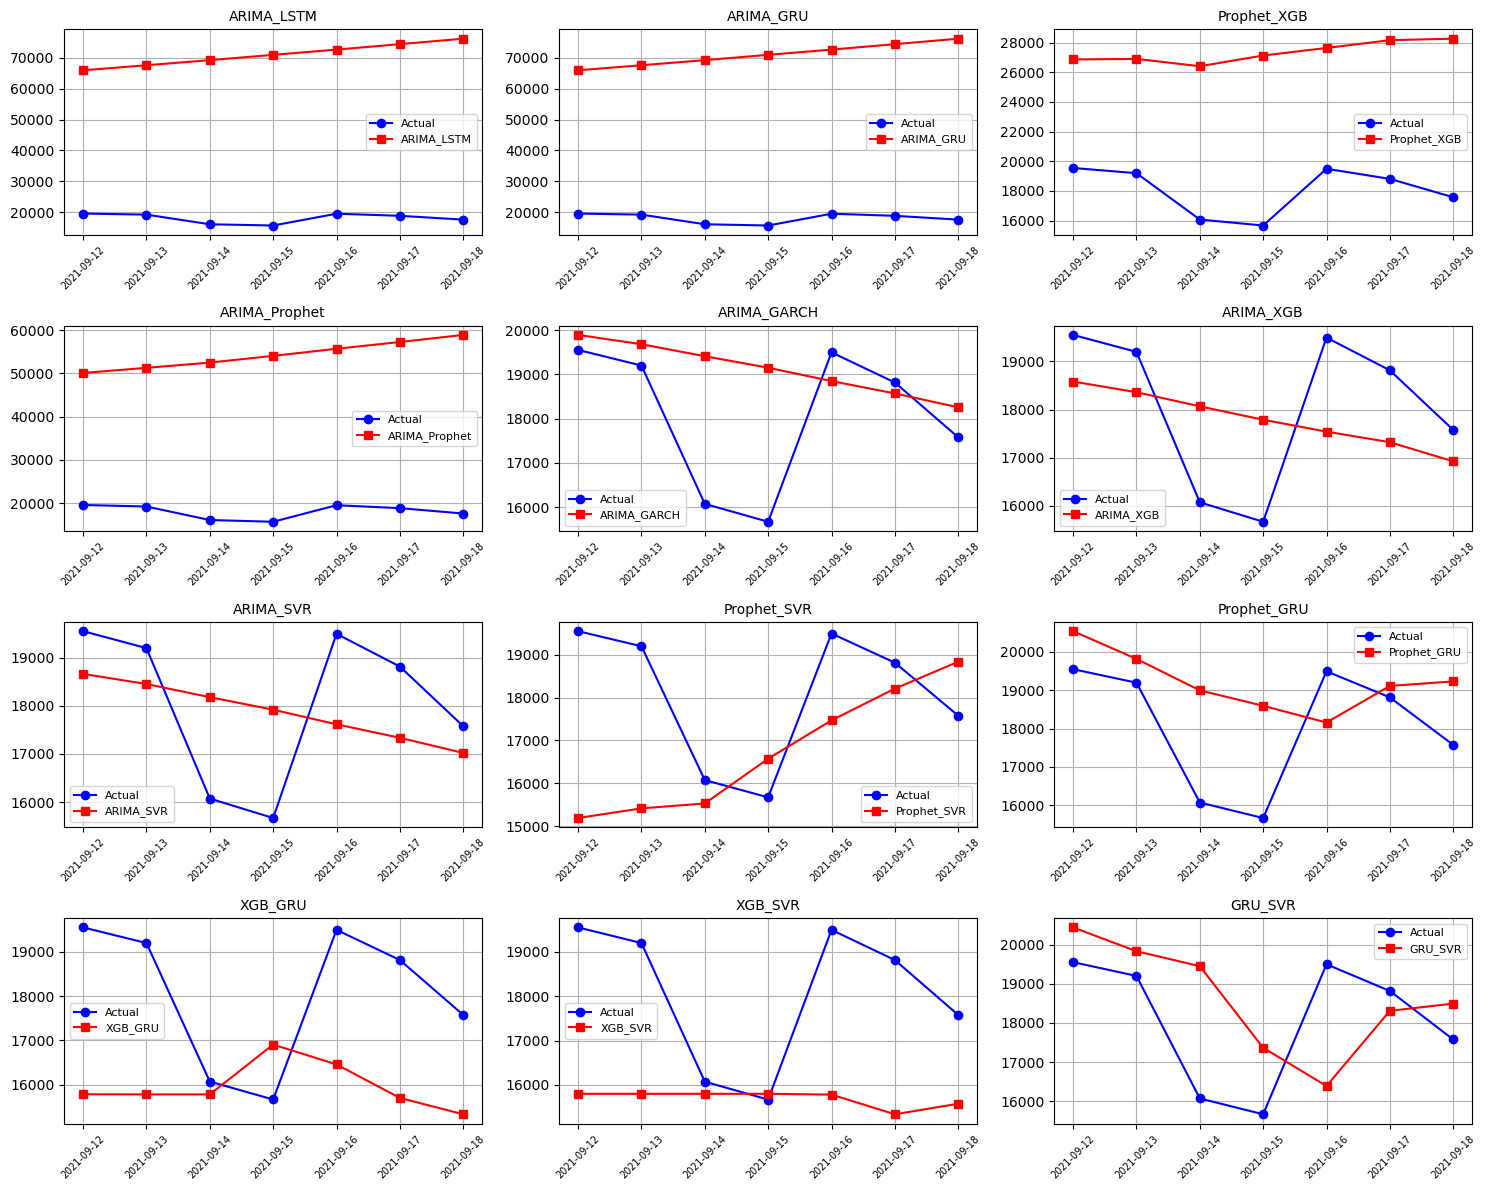

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# ==========================
# Common Actual Values
# ==========================
dates = [
    "2021-09-12","2021-09-13","2021-09-14",
    "2021-09-15","2021-09-16","2021-09-17","2021-09-18"
]
actual = [19550, 19198, 16073, 15669, 19495, 18815, 17577]

# ==========================
# All Hybrid Forecasts (Added ARIMA_GRU)
# ==========================
data = {
    "Date": pd.to_datetime(dates),
    "Actual": actual,

    "ARIMA_LSTM":   [65995.885472, 67633.296042, 69286.422196,
                    71006.829293, 72705.700628, 74469.331365, 76249.108622],

    "ARIMA_GRU":    [65995.885472, 67633.296042, 69286.422196,
                    71006.829293, 72705.700628, 74469.331365, 76249.108622],  # ✅ Added

    "Prophet_XGB": [26870.635146, 26907.275203, 26412.364582,
                    27135.298217, 27643.897871, 28169.212570, 28270.900755],

    "ARIMA_Prophet": [50086.210245, 51269.560064, 52488.046205,
                      54042.873172, 55682.002183, 57245.172052, 58886.783978],

    "ARIMA_GARCH": [19889.023368, 19679.098400, 19408.358304,
                    19148.447731, 18846.563228, 18567.550940, 18254.412532],

    "ARIMA_XGB":   [18581.642604, 18360.123258, 18066.719653,
                    17788.567470, 17541.034143, 17322.356200, 16923.698915],

    "ARIMA_SVR":   [18662.899011, 18451.964222, 18179.512346,
                    17918.917917, 17615.775604, 17335.692594, 17021.280502],

    "Prophet_SVR": [15186.629889, 15412.545807, 15526.585213,
                    16571.980393, 17467.747823, 18207.659299, 18835.699186],

    "Prophet_GRU": [20541.261556, 19817.993666, 18998.092260,
                    18595.234371, 18158.466343, 19114.277939, 19231.264407],

    "XGB_GRU":     [15786.579102, 15783.865234, 15784.363281,
                    16907.992188, 16460.464844, 15704.688477, 15335.809570],

    "XGB_SVR":     [15799.416728, 15799.416728, 15799.416728,
                    15799.416728, 15781.438212, 15338.283915, 15575.117900],

    "GRU_SVR":     [20436, 19829, 19448, 17366, 16390, 18308, 18492]
}

df = pd.DataFrame(data)

# ==========================
# Subplots (each model separate)
# ==========================
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

for i, model in enumerate(df.columns[2:]):  # Skip Date + Actual
    axes[i].plot(df["Date"], df["Actual"], marker="o", label="Actual", color="blue")
    axes[i].plot(df["Date"], df[model], marker="s", label=model, color="red")
    axes[i].set_title(model, fontsize=10)
    axes[i].legend(fontsize=8)
    axes[i].grid(True)

    # 🔹 Fix x-axis overlap
    axes[i].tick_params(axis="x", rotation=45, labelsize=7)

# Remove unused subplot (since now you have 12 models, 4x3 fits perfectly)
plt.tight_layout()
plt.show()


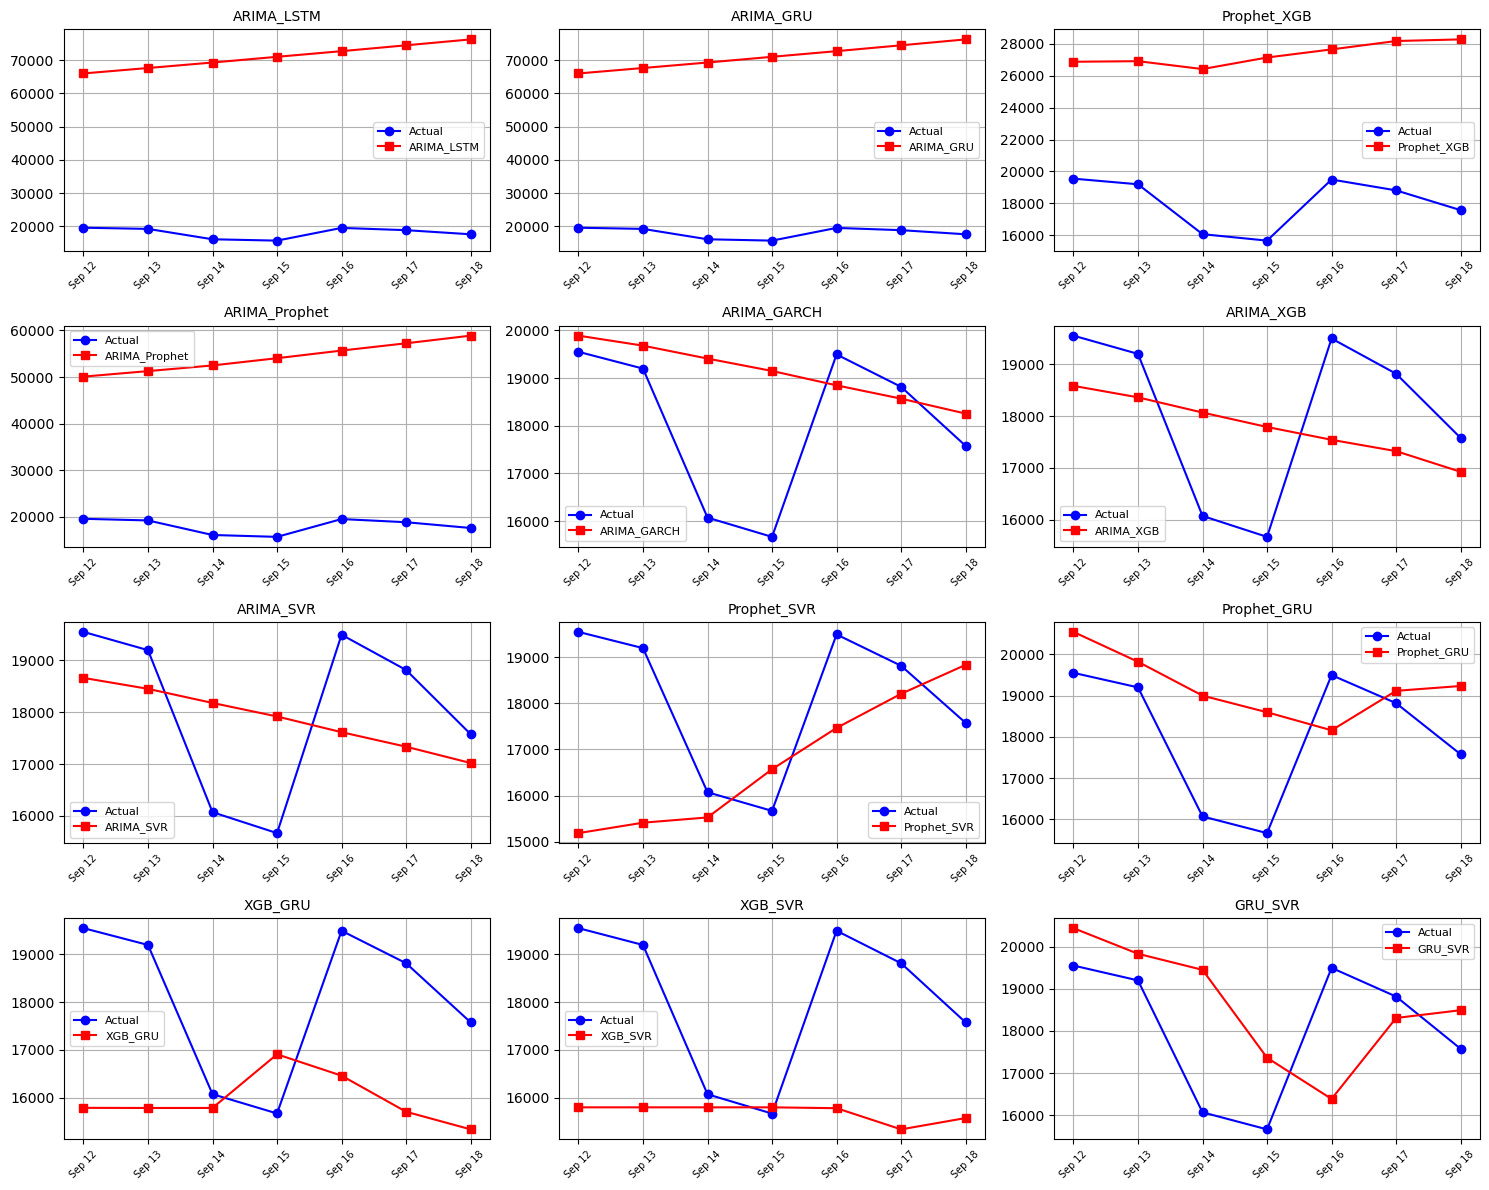

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# ==========================
# Common Actual Values
# ==========================
dates = [
    "2021-09-12","2021-09-13","2021-09-14",
    "2021-09-15","2021-09-16","2021-09-17","2021-09-18"
]
actual = [19550, 19198, 16073, 15669, 19495, 18815, 17577]

# ==========================
# All Hybrid Forecasts (Added ARIMA_GRU)
# ==========================
data = {
    "Date": pd.to_datetime(dates),
    "Actual": actual,

    "ARIMA_LSTM":   [65995.885472, 67633.296042, 69286.422196,
                    71006.829293, 72705.700628, 74469.331365, 76249.108622],

    "ARIMA_GRU":    [65995.885472, 67633.296042, 69286.422196,
                    71006.829293, 72705.700628, 74469.331365, 76249.108622],  # ✅ Added

    "Prophet_XGB": [26870.635146, 26907.275203, 26412.364582,
                    27135.298217, 27643.897871, 28169.212570, 28270.900755],

    "ARIMA_Prophet": [50086.210245, 51269.560064, 52488.046205,
                      54042.873172, 55682.002183, 57245.172052, 58886.783978],

    "ARIMA_GARCH": [19889.023368, 19679.098400, 19408.358304,
                    19148.447731, 18846.563228, 18567.550940, 18254.412532],

    "ARIMA_XGB":   [18581.642604, 18360.123258, 18066.719653,
                    17788.567470, 17541.034143, 17322.356200, 16923.698915],

    "ARIMA_SVR":   [18662.899011, 18451.964222, 18179.512346,
                    17918.917917, 17615.775604, 17335.692594, 17021.280502],

    "Prophet_SVR": [15186.629889, 15412.545807, 15526.585213,
                    16571.980393, 17467.747823, 18207.659299, 18835.699186],

    "Prophet_GRU": [20541.261556, 19817.993666, 18998.092260,
                    18595.234371, 18158.466343, 19114.277939, 19231.264407],

    "XGB_GRU":     [15786.579102, 15783.865234, 15784.363281,
                    16907.992188, 16460.464844, 15704.688477, 15335.809570],

    "XGB_SVR":     [15799.416728, 15799.416728, 15799.416728,
                    15799.416728, 15781.438212, 15338.283915, 15575.117900],

    "GRU_SVR":     [20436, 19829, 19448, 17366, 16390, 18308, 18492]
}

df = pd.DataFrame(data)

# 🔹 Format dates as "Sep 12", "Sep 13", etc.
df["DateLabel"] = df["Date"].dt.strftime("%b %d")

# ==========================
# Subplots (each model separate)
# ==========================
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

for i, model in enumerate(df.columns[2:-1]):  # skip Date, Actual, DateLabel
    axes[i].plot(df["DateLabel"], df["Actual"], marker="o", label="Actual", color="blue")
    axes[i].plot(df["DateLabel"], df[model], marker="s", label=model, color="red")
    axes[i].set_title(model, fontsize=10)
    axes[i].legend(fontsize=8)
    axes[i].grid(True)
    axes[i].tick_params(axis="x", rotation=45, labelsize=7)

plt.tight_layout()
plt.show()



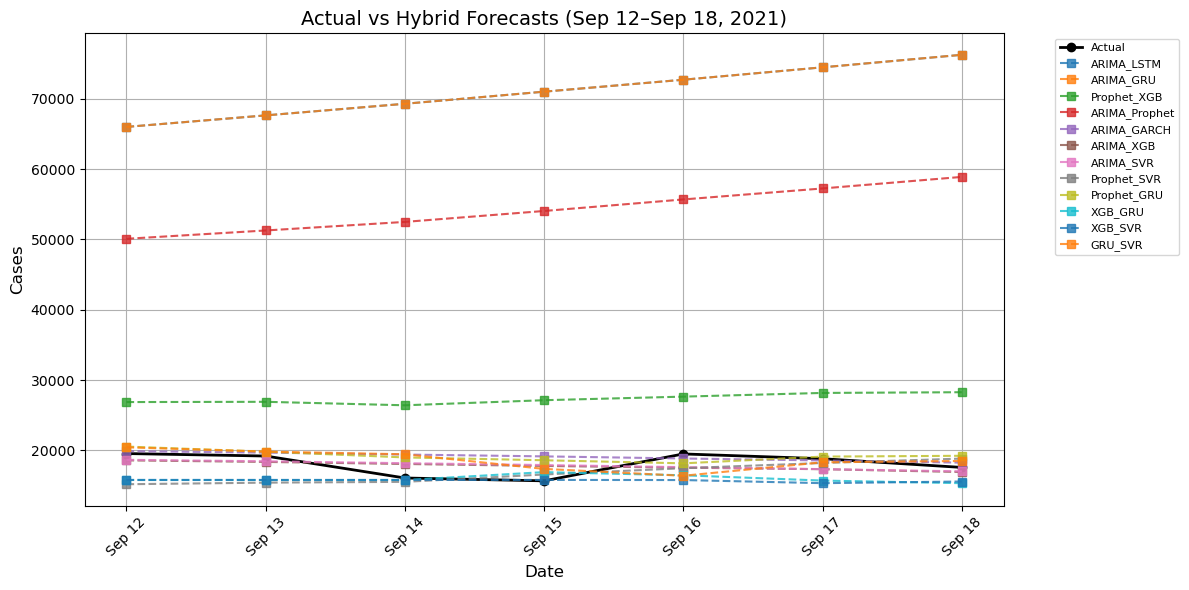

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# ==========================
# Common Actual Values
# ==========================
dates = [
    "2021-09-12","2021-09-13","2021-09-14",
    "2021-09-15","2021-09-16","2021-09-17","2021-09-18"
]
actual = [19550, 19198, 16073, 15669, 19495, 18815, 17577]

# ==========================
# All Hybrid Forecasts (with ARIMA_GRU)
# ==========================
data = {
    "Date": pd.to_datetime(dates),
    "Actual": actual,

    "ARIMA_LSTM":   [65995.885472, 67633.296042, 69286.422196,
                    71006.829293, 72705.700628, 74469.331365, 76249.108622],

    "ARIMA_GRU":    [65995.885472, 67633.296042, 69286.422196,
                    71006.829293, 72705.700628, 74469.331365, 76249.108622],

    "Prophet_XGB": [26870.635146, 26907.275203, 26412.364582,
                    27135.298217, 27643.897871, 28169.212570, 28270.900755],

    "ARIMA_Prophet": [50086.210245, 51269.560064, 52488.046205,
                      54042.873172, 55682.002183, 57245.172052, 58886.783978],

    "ARIMA_GARCH": [19889.023368, 19679.098400, 19408.358304,
                    19148.447731, 18846.563228, 18567.550940, 18254.412532],

    "ARIMA_XGB":   [18581.642604, 18360.123258, 18066.719653,
                    17788.567470, 17541.034143, 17322.356200, 16923.698915],

    "ARIMA_SVR":   [18662.899011, 18451.964222, 18179.512346,
                    17918.917917, 17615.775604, 17335.692594, 17021.280502],

    "Prophet_SVR": [15186.629889, 15412.545807, 15526.585213,
                    16571.980393, 17467.747823, 18207.659299, 18835.699186],

    "Prophet_GRU": [20541.261556, 19817.993666, 18998.092260,
                    18595.234371, 18158.466343, 19114.277939, 19231.264407],

    "XGB_GRU":     [15786.579102, 15783.865234, 15784.363281,
                    16907.992188, 16460.464844, 15704.688477, 15335.809570],

    "XGB_SVR":     [15799.416728, 15799.416728, 15799.416728,
                    15799.416728, 15781.438212, 15338.283915, 15575.117900],

    "GRU_SVR":     [20436, 19829, 19448, 17366, 16390, 18308, 18492]
}


# ==========================
# 2. Combined Plot (Actual vs all hybrids)
# ==========================
plt.figure(figsize=(12, 6))

# Actual
plt.plot(df["DateLabel"], df["Actual"], marker="o", color="black", linewidth=2, label="Actual")

# Hybrids
for model in df.columns[2:-1]:  # all models except Date, Actual, DateLabel
    plt.plot(df["DateLabel"], df[model], marker="s", linestyle="--", label=model, alpha=0.8)

plt.title("Actual vs Hybrid Forecasts (Sep 12–Sep 18, 2021)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cases", fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()
